In [1]:
import pandas as pd
from reformat import find_index
import itertools

In [2]:
index_set = find_index("../DSPy_results_batch_1000_dedup_with_prev_msg_w_ref/identifier_results.jsonl")
raw_data = pd.read_csv("../data/input_data/prospective_sample_1000_with_pat_data.csv")
raw_data_600 = pd.read_csv("../data/input_data/prospective_sample_600_with_pat_data.csv")
raw_data = raw_data[raw_data["index"].isin(index_set)]
raw_data = pd.concat([raw_data_600, raw_data], axis=0, ignore_index=True)
cleaned_raw = raw_data[["index", "QuickAction Executed", "Department Specialty Title"]]

In [4]:
baseline_error_df = pd.read_csv("../DSPy_results_batch_1000_dedup_with_prev_msg/raw_df.csv")
enhance_error_df = pd.read_csv("../DSPy_results_batch_1000_dedup_with_prev_msg_w_ref/raw_df.csv")

In [5]:
error_types = pd.read_csv("../data/input_data/dedup_codebook.csv").drop(columns=["Dedup Definition"])
error_types = error_types.rename(columns={
    'Dedup Error Code': 'error_code',
    'Dedup Subdomain': 'subdomain',
    'Dedup Domain': 'domain'
})


In [6]:
import pandas as pd
import itertools

def build_no_error_df(index_set, error_df, error_types, rationale_text="Labeled No Error"):
    """
    Create a DataFrame of all (non-error index, error_type) pairs, filled as 'no error' rows.
    
    Parameters:
        index_set: set or list of all canonical indices
        error_df: DataFrame containing only error rows (must have 'index' column)
        error_types: DataFrame with columns: ['domain', 'subdomain', 'error_code']
        rationale_text: string to use for rationale columns (default: "Labeled No Error")
        
    Returns:
        df_correct: DataFrame with all required columns, for non-error indices.
    """
    # Compute non-error indices
    error_indices = set(error_df["index"].unique())
    non_error_indices = list(set(index_set) - error_indices)
    assert len(non_error_indices) + len(error_indices) == len(index_set)
    
    # All possible pairs
    correct_rows = list(itertools.product(non_error_indices, error_types.index))
    df_correct = pd.DataFrame(correct_rows, columns=['index', 'error_tuple_idx'])
    
    # Merge error type details
    df_correct = df_correct.merge(
        error_types.reset_index(drop=True), left_on='error_tuple_idx', right_index=True)
    
    # Fill columns
    df_correct['subdomain_yes'] = False
    df_correct['subdomain_rationale'] = rationale_text
    df_correct['error_code_yes'] = False
    df_correct['error_code_rationale'] = rationale_text
    
    # Drop helper column and reorder
    df_correct = df_correct.drop(columns=['error_tuple_idx'])
    df_correct = df_correct[['index', 'domain', 'subdomain', 'subdomain_yes', 'subdomain_rationale',
                             'error_code', 'error_code_yes', 'error_code_rationale']]
    return df_correct



In [7]:
df_correct_baseline = build_no_error_df(index_set, baseline_error_df, error_types)
df_correct_baseline["has_error"] = False
df_correct_enhance  = build_no_error_df(index_set, enhance_error_df,  error_types)
df_correct_enhance["has_error"] = False
baseline_error_df["has_error"] = True
enhance_error_df["has_error"] = True
df_full_baseline = pd.concat([baseline_error_df, df_correct_baseline], axis=0, ignore_index=True)
df_full_enhance = pd.concat([enhance_error_df, df_correct_enhance], axis=0, ignore_index=True)


In [8]:



df_full_baseline.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg/full_df.csv", index=False)
df_full_enhance.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg_w_ref/full_df.csv", index=False)
# df_full_baseline = pd.read_csv("../DSPy_results_batch_600_dedup_with_prev_msg/full_df.csv")
# df_full_enhance = pd.read_csv("../DSPy_results_batch_600_dedup_with_prev_msg_w_ref/full_df.csv")
assert df_full_baseline["index"].nunique() == len(index_set)
assert df_full_enhance["index"].nunique() == len(index_set)
assert df_full_baseline["index"].nunique() == df_full_enhance["index"].nunique()

In [9]:
# df_full_baseline.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg/full_df.csv", index=False)
# df_full_enhance.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg_w_ref/full_df.csv", index=False)
df_full_baseline_600 = pd.read_csv("../DSPy_results_batch_600_dedup_with_prev_msg/full_df.csv")
df_full_enhance_600 = pd.read_csv("../DSPy_results_batch_600_dedup_with_prev_msg_w_ref/full_df.csv")

In [10]:
df_full_baseline = pd.concat([df_full_baseline_600, df_full_baseline], axis=0, ignore_index=True)
df_full_enhance = pd.concat([df_full_enhance_600, df_full_enhance], axis=0, ignore_index=True)


In [11]:
# df_full_baseline.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg/full_df_combined_with_600.csv", index=False)
# df_full_enhance.to_csv("../DSPy_results_batch_1000_dedup_with_prev_msg_w_ref/full_df_combined_with_600.csv", index=False)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_transition_heatmap(
    df_full_baseline, 
    df_full_enhance, 
    group_col="domain",
    method="multi",
    figsize=(32, 22),
    title=None,
    truncate=22,
    font_scale=1.6,
    legend_truncate=40,
    num_font=32,      # Numerator font (cell count)
    pct_font=22,      # Percent font
    rowtot_font=28,   # Row total font
    legend_label_font=26,
):
    def truncate_middle(label, max_len=22):
        label = str(label)
        if len(label) <= max_len:
            return label
        half = (max_len - 3) // 2
        return f"{label[:half]}...{label[-half:]}"
    
    def get_case_label(df_full):
        if method == "multi":
            label = (
                df_full[df_full['has_error'] & df_full["error_code_yes"]]
                .groupby('index')[group_col]
                .unique()
                .reset_index()
            )
            all_indices = pd.DataFrame({'index': df_full['index'].unique()})
            label = pd.merge(all_indices, label, on='index', how='left')
            label[group_col] = label[group_col].apply(
                lambda x: x if isinstance(x, (list, tuple, pd.Series, np.ndarray)) else ["no error found"]
            )
            label = label.explode(group_col)
        elif method == "most":
            errors = df_full[df_full["has_error"] & df_full["error_code_yes"]]
            counts = errors.groupby(['index', group_col]).size().reset_index(name='count')
            idx = counts.groupby('index')['count'].idxmax()
            label_series = counts.loc[idx].set_index('index')[group_col]
            all_indices = pd.Series(df_full['index'].unique(), name='index')
            label = all_indices.to_frame().set_index('index')
            label[group_col] = "no error found"
            label.update(label_series)
            label = label.reset_index()
        else:
            label_series = (
                df_full[df_full['has_error'] & df_full['error_code_yes']]
                .groupby('index')[group_col]
                .first()
            )
            all_indices = pd.Series(df_full['index'].unique(), name='index')
            label = all_indices.to_frame().set_index('index')
            label[group_col] = "no error found"
            label.update(label_series)
            label = label.reset_index()
        return label

    baseline_labels = get_case_label(df_full_baseline).rename(columns={group_col: f'{group_col}_baseline'})
    enhanced_labels = get_case_label(df_full_enhance).rename(columns={group_col: f'{group_col}_enhanced'})
    df_compare = pd.merge(baseline_labels, enhanced_labels, on='index')

    all_labels = sorted(set(df_compare[f'{group_col}_baseline']).union(set(df_compare[f'{group_col}_enhanced'])))
    label_to_num = {label: str(i+1) for i, label in enumerate(all_labels)}
    num_to_label = {str(i+1): label for i, label in enumerate(all_labels)}

    transition_counts = pd.crosstab(
        df_compare[f'{group_col}_baseline'],
        df_compare[f'{group_col}_enhanced']
    ).reindex(index=all_labels, columns=all_labels, fill_value=0)
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0) * 100

    counts = transition_counts.values
    totals = transition_counts.sum(axis=1).values
    pct = transition_matrix.values

    num_labels = [label_to_num[label] for label in all_labels]

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        transition_matrix,
        annot=False,
        cmap="Blues",
        vmin=0,
        vmax=100,
        linewidths=3.0,
        linecolor='white',
        ax=ax,
        cbar_kws={"shrink": 0.6}
    )
    # Make colorbar ticks and label bigger
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=28, width=3, length=11)
    cbar.set_label('Percentage (%)', fontsize=32, fontweight='bold', labelpad=22)

    # Only numerator and percent per cell, row total once at end
    for y in range(transition_matrix.shape[0]):
        for x in range(transition_matrix.shape[1]):
            count = counts[y, x]
            total = totals[y]
            percent = pct[y, x]
            if total > 0:
                ax.text(
                    x + 0.5, y + 0.44, f"{count}",
                    fontsize=num_font, fontweight='bold',
                    color='black' if percent < 65 else 'white',
                    ha='center', va='center', family='monospace'
                )
                ax.text(
                    x + 0.5, y + 0.73, f"{percent:.0f}%",
                    fontsize=pct_font, fontweight='normal',
                    color='#444444' if percent < 65 else '#e6e6e6',
                    ha='center', va='center'
                )
        # Row total at far right
        ax.text(
            transition_matrix.shape[1] + 0.18, y + 0.44, f"/{totals[y]}",
            fontsize=rowtot_font, fontweight='bold', color='dimgray',
            ha='left', va='center', family='monospace'
        )

    # Extend x-axis for row totals
    ax.set_xlim(-0.5, transition_matrix.shape[1] + 1)

    # Axis ticks/labels
    ax.set_yticklabels(num_labels, fontsize=int(18*font_scale), fontweight="bold")
    ax.set_xticklabels(num_labels, fontsize=int(18*font_scale), fontweight="bold", rotation=0, ha='center')
    ax.tick_params(axis='both', which='major', pad=18)

    if not title:
        title = f"Transition Confusion Matrix ({group_col.capitalize()}, Method: {method})"
    plt.title(title, fontsize=int(28*font_scale), fontweight="bold", pad=int(26*font_scale))
    plt.xlabel(f"Enhanced {group_col.capitalize()} (see legend)", fontsize=int(22*font_scale), fontweight="bold", labelpad=int(20*font_scale))
    plt.ylabel(f"Baseline {group_col.capitalize()} (see legend)", fontsize=int(22*font_scale), fontweight="bold", labelpad=int(20*font_scale))

    plt.tight_layout(rect=[0, 0, 0.80, 1])
    plt.subplots_adjust(left=0.12, right=0.80, top=0.93, bottom=0.08)

    legend_text = "\n".join([
        r'$\bf{' + num + r'}$' + "  " + f"{truncate_middle(label, legend_truncate)}"
        for num, label in num_to_label.items()
    ])
    legend_box = dict(boxstyle="round,pad=1.0", edgecolor="black", facecolor="#f7f7f7", alpha=0.97)
    plt.gcf().text(
        0.84, 0.5, "Legend:\n\n" + legend_text, va='center', ha='left',
        fontsize=legend_label_font, fontweight="normal", family="monospace", bbox=legend_box, linespacing=2.3
    )

    plt.show()


In [32]:
def check_label_ties(df_full, group_col='domain'):
    # Only count errors
    errors = df_full[df_full["has_error"] & df_full["error_code_yes"]]
    # Count occurrences of each label per index
    counts = errors.groupby(['index', group_col]).size().reset_index(name='count')
    # Find max count per index
    max_counts = counts.groupby('index')['count'].transform('max')
    # Get only those with max count (could be multiple per index)
    tied = counts[counts['count'] == max_counts]
    # Group by index to see if any index has more than one tied label
    ties = tied.groupby('index')[group_col].apply(list)
    # Filter for ties (list with >1 label)
    ties = ties[ties.apply(lambda x: len(x) > 1)]
    return ties

# Check ties at domain level
domain_ties = check_label_ties(df_full_baseline, group_col='domain')
print("Domain-level ties (baseline):")
print(domain_ties)

# If you want to check on enhanced data too:
# domain_ties_enhanced = check_label_ties(df_full_enhance, group_col='domain')

# Check ties at subdomain level
subdomain_ties = check_label_ties(df_full_baseline, group_col='subdomain')
print("Subdomain-level ties (baseline):")
print(subdomain_ties)


Domain-level ties (baseline):
index
5598      [Clinical Reasoning, Communication Quality & R...
10482     [Bias & Stigmatization, Clinical Reasoning, Co...
15449     [Clinical Reasoning, Communication Quality & R...
16961     [Clinical Reasoning, Communication Quality & R...
18694     [Clinical Reasoning, Communication Quality & R...
                                ...                        
814452    [Clinical Reasoning, Communication Quality & R...
817177    [Clinical Reasoning, Communication Quality & R...
821338    [Clinical Reasoning, Communication Quality & R...
832480    [Clinical Reasoning, Communication Quality & R...
842919    [Clinical Reasoning, Communication Quality & R...
Name: domain, Length: 118, dtype: object
Subdomain-level ties (baseline):
index
5598              [Comprehension of Patient Query, Empathy]
10482     [Clarity, Comprehension of Patient Context, Id...
14858     [Clarity, Clinical Recommendations, Comprehens...
15271     [Clarity, Clinical Recommendations

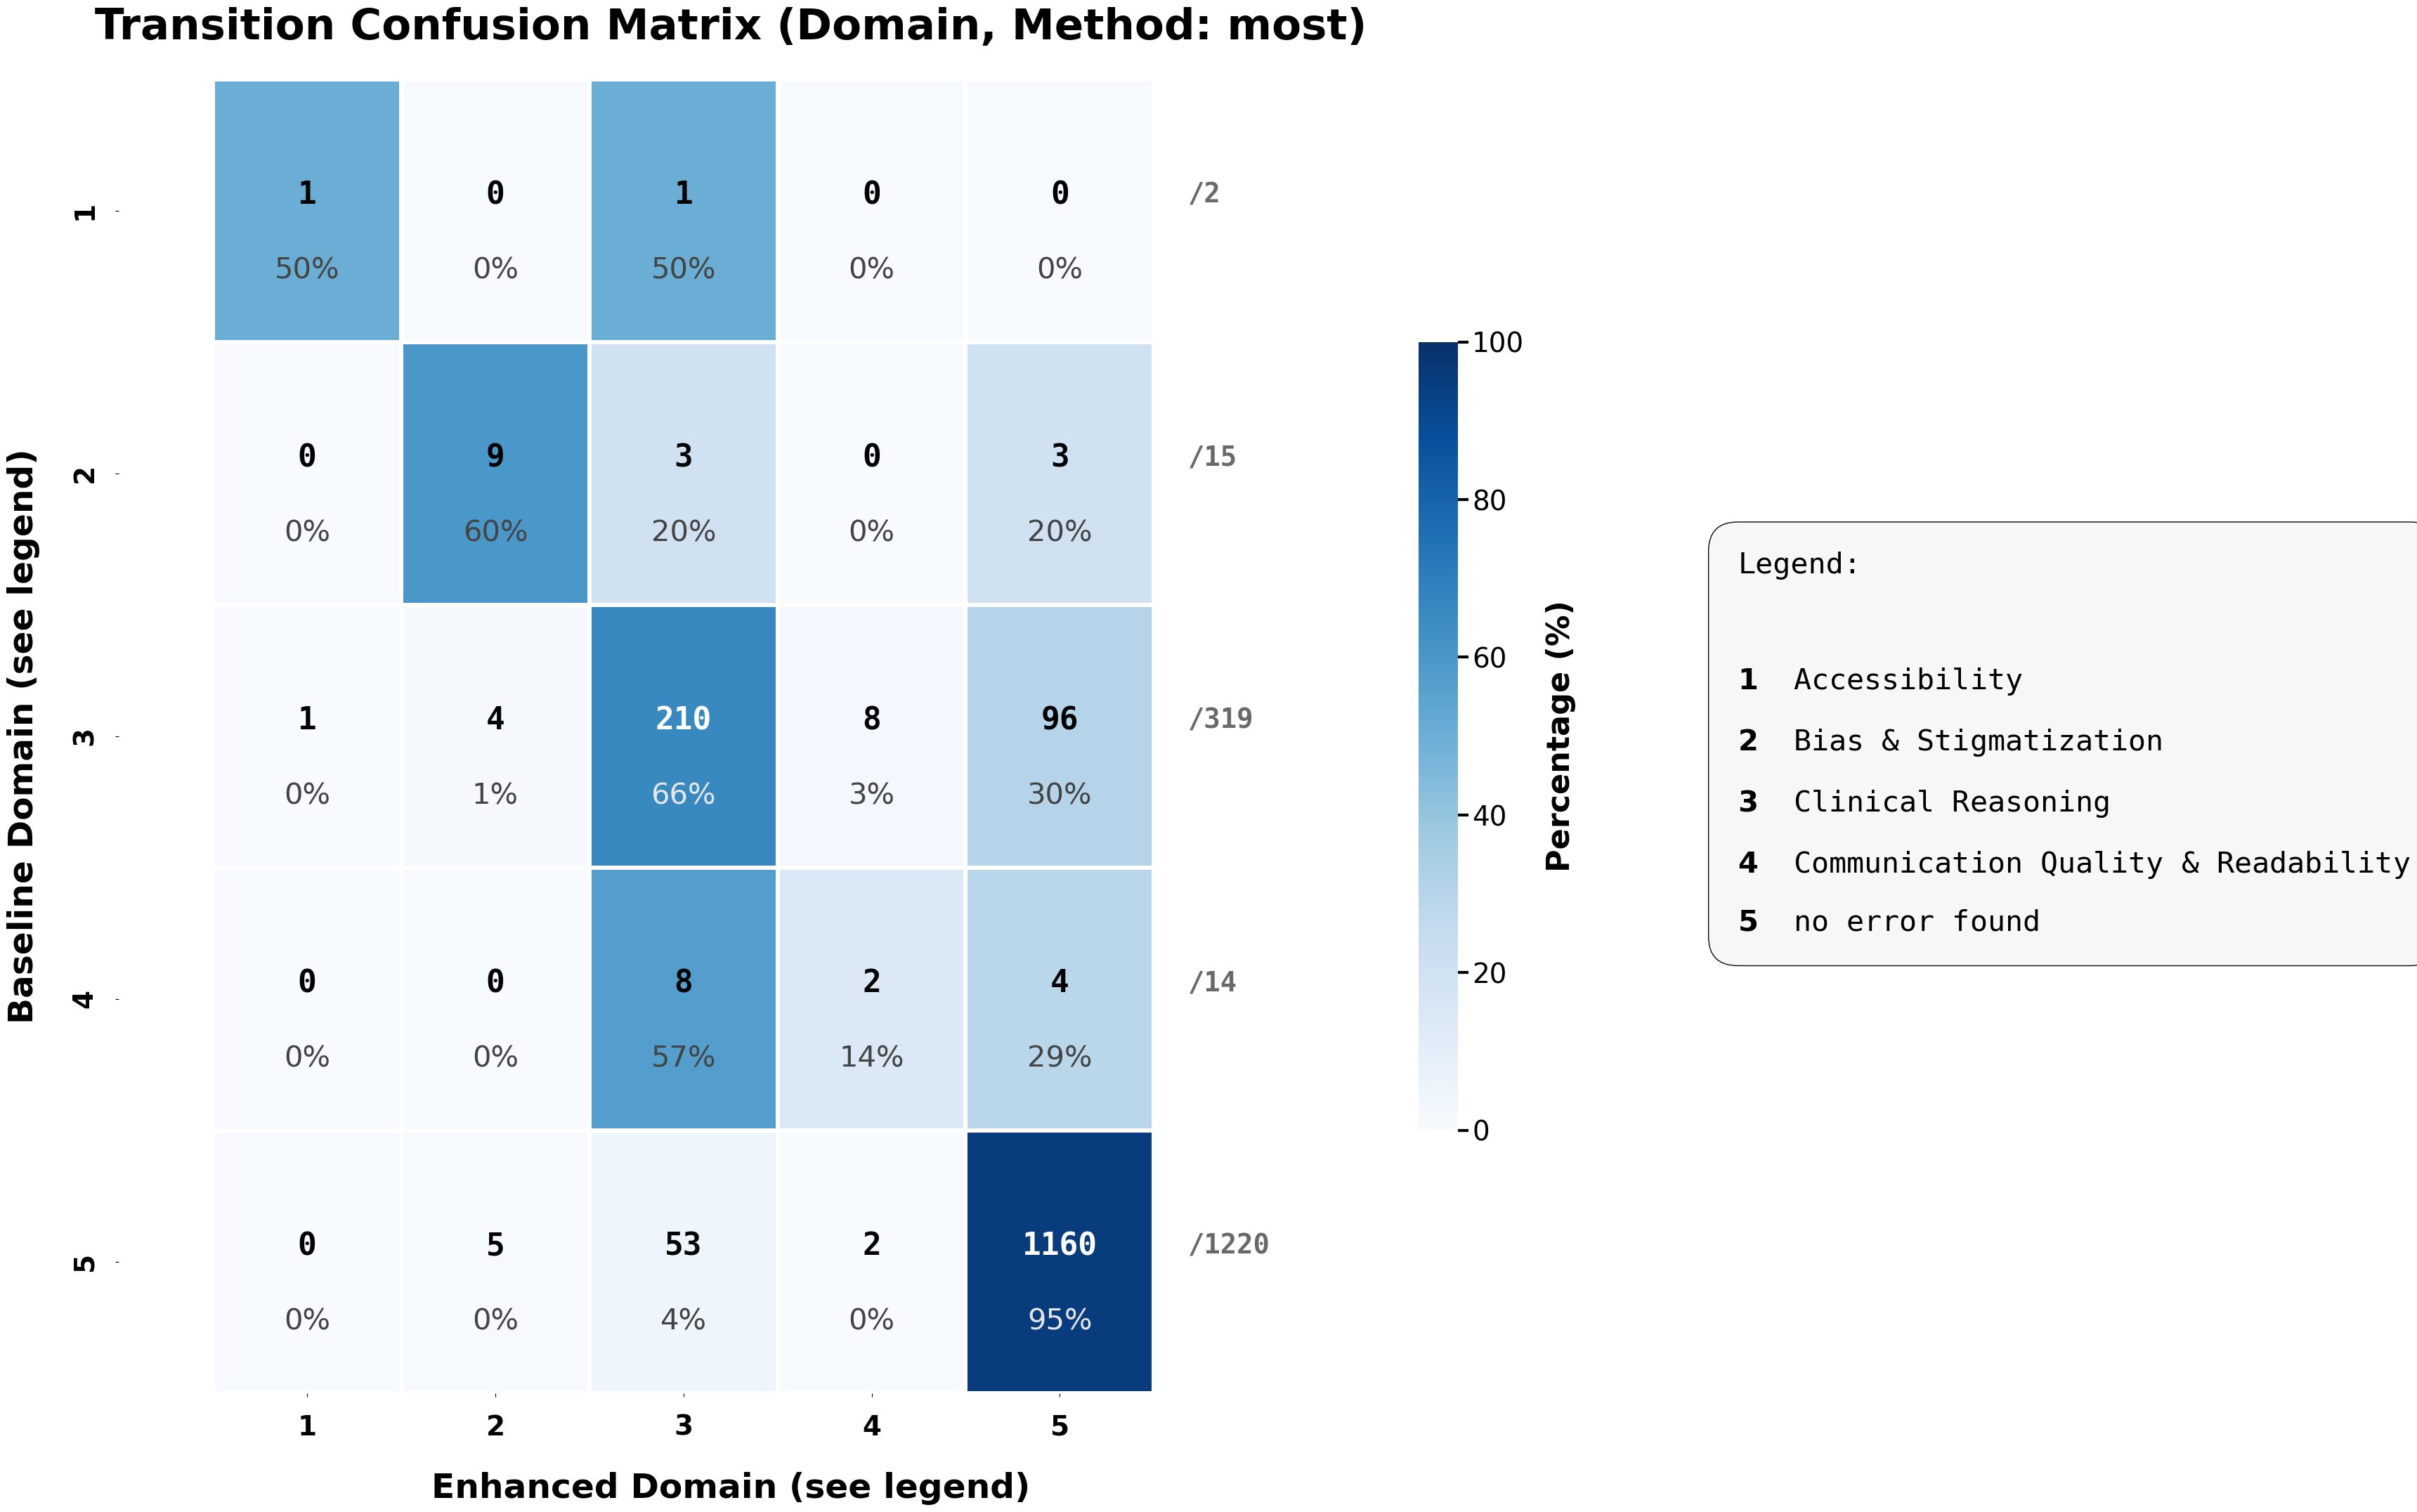

In [13]:
plot_error_transition_heatmap(df_full_baseline, df_full_enhance, group_col="domain", method="most", pct_font = 30, legend_label_font= 30)

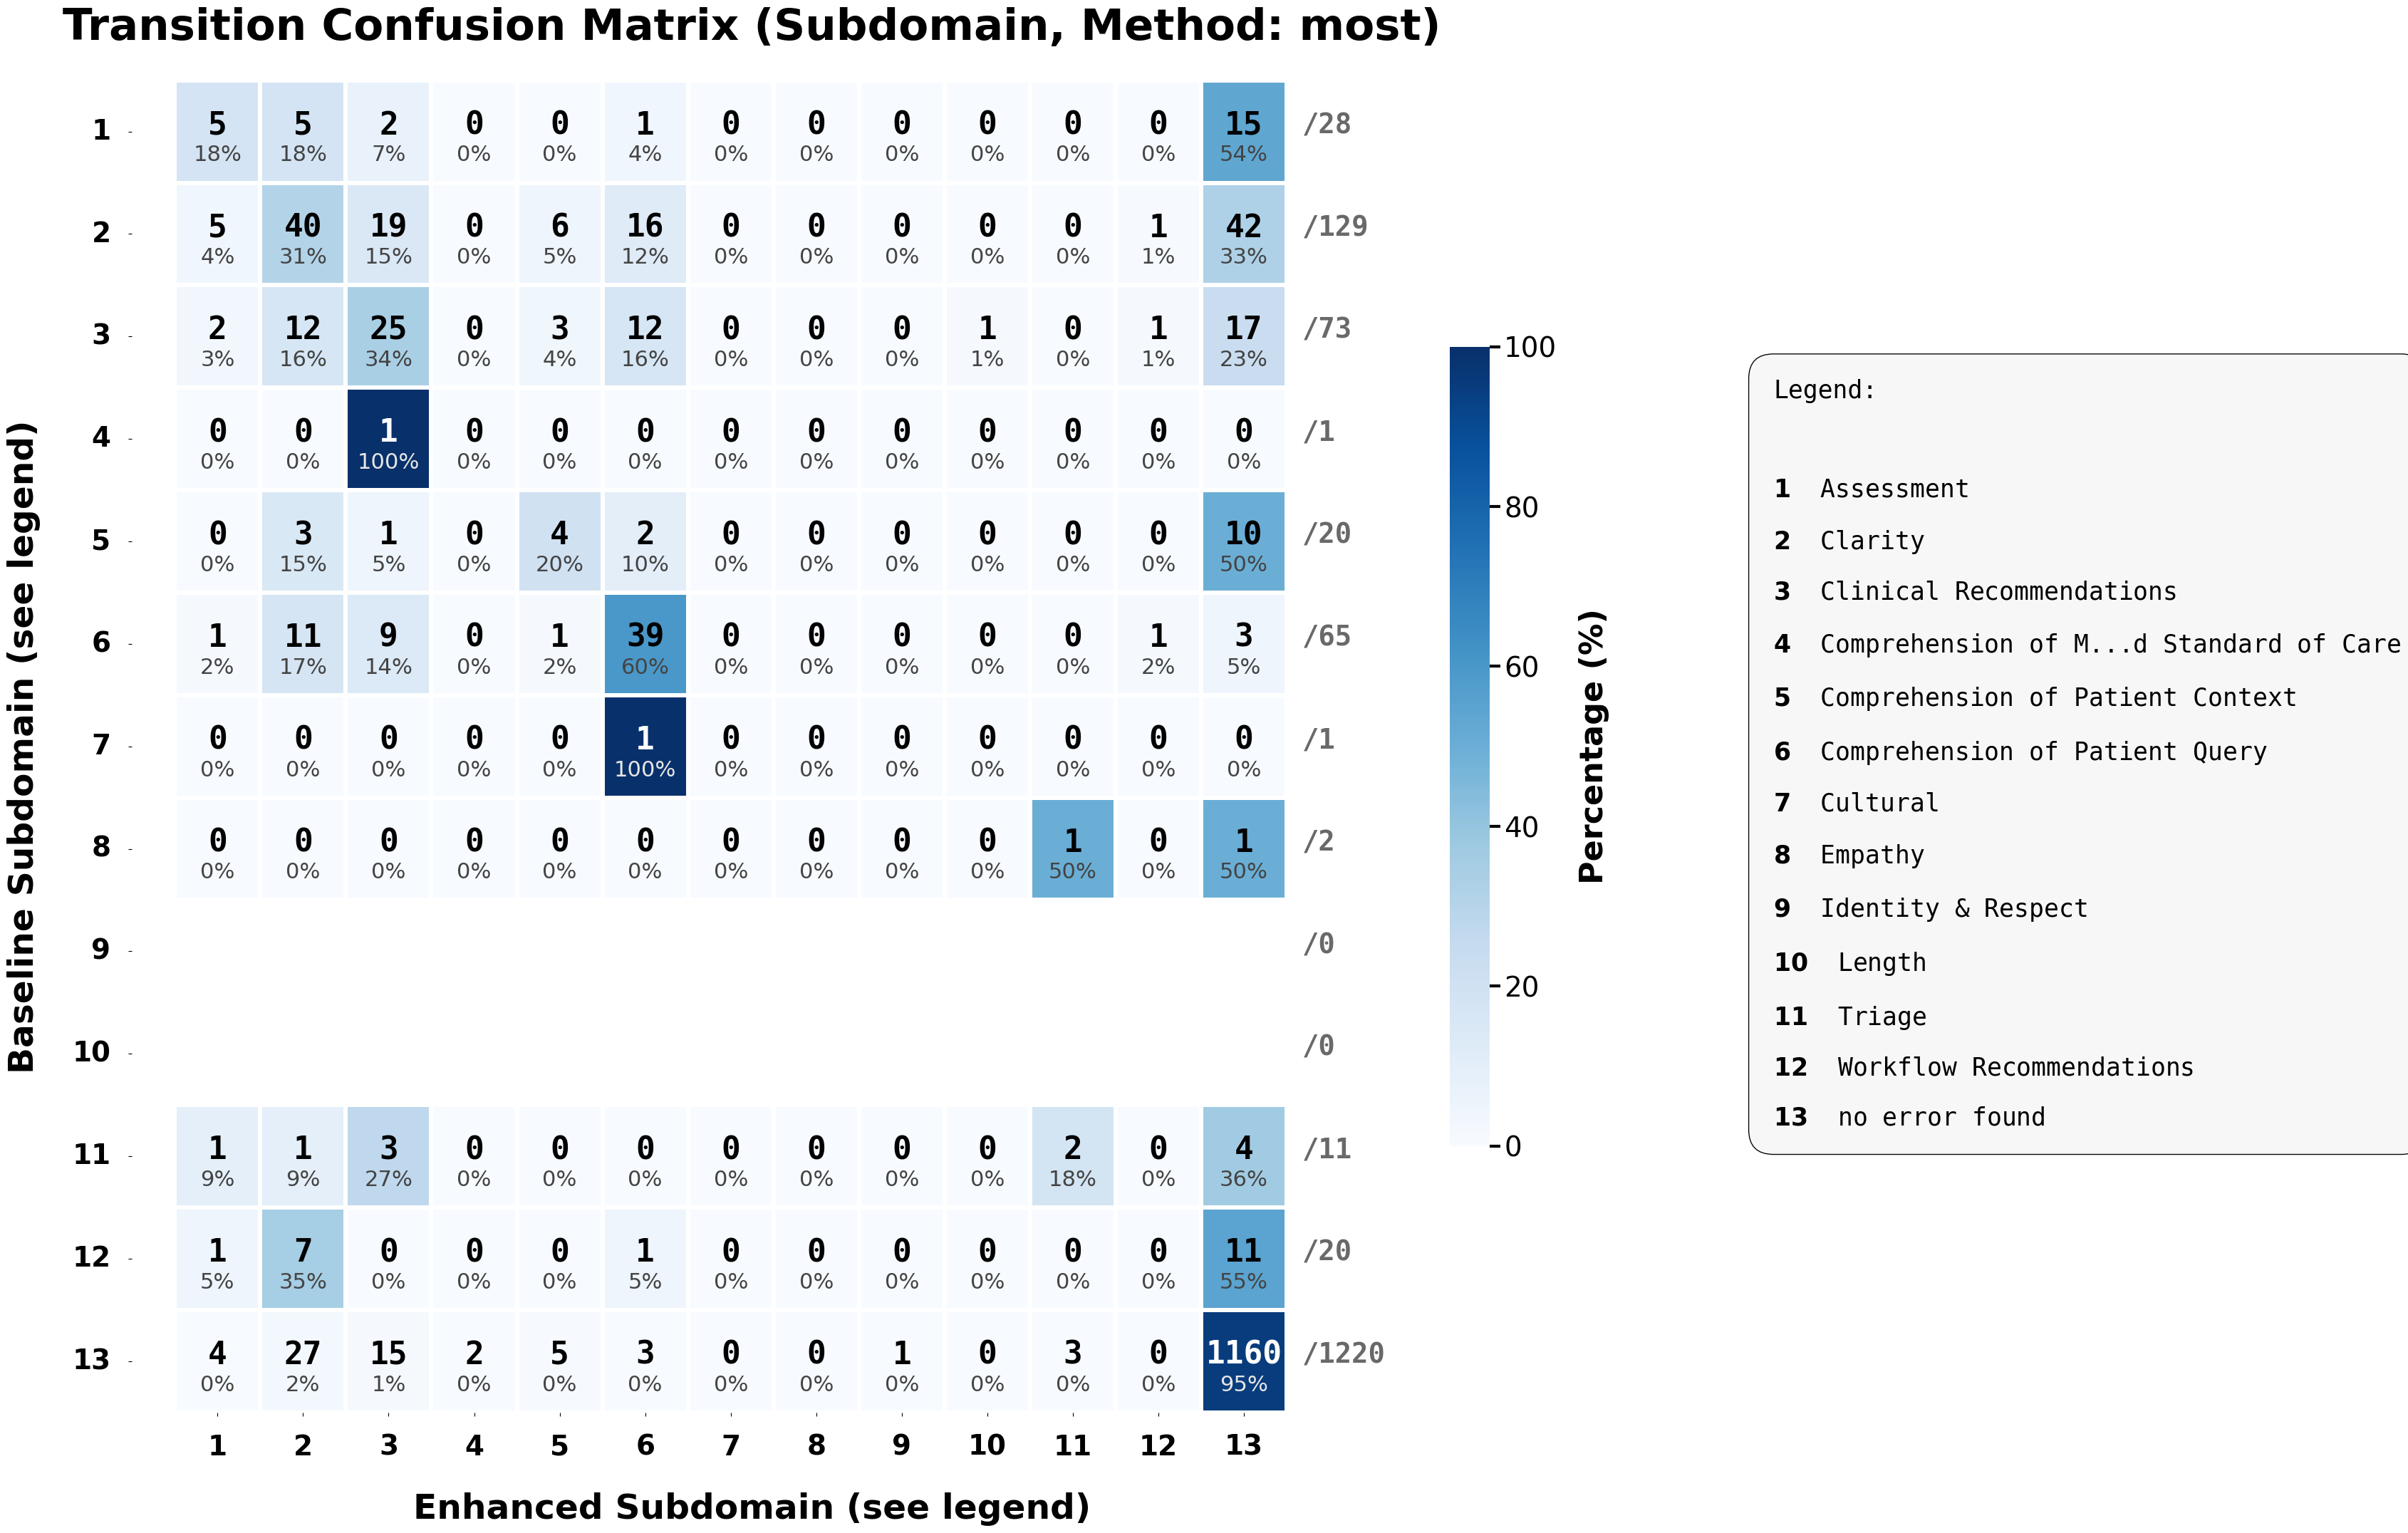

In [14]:
plot_error_transition_heatmap(df_full_baseline, df_full_enhance, group_col="subdomain", method="most", legend_label_font= 25, pct_font = 22)


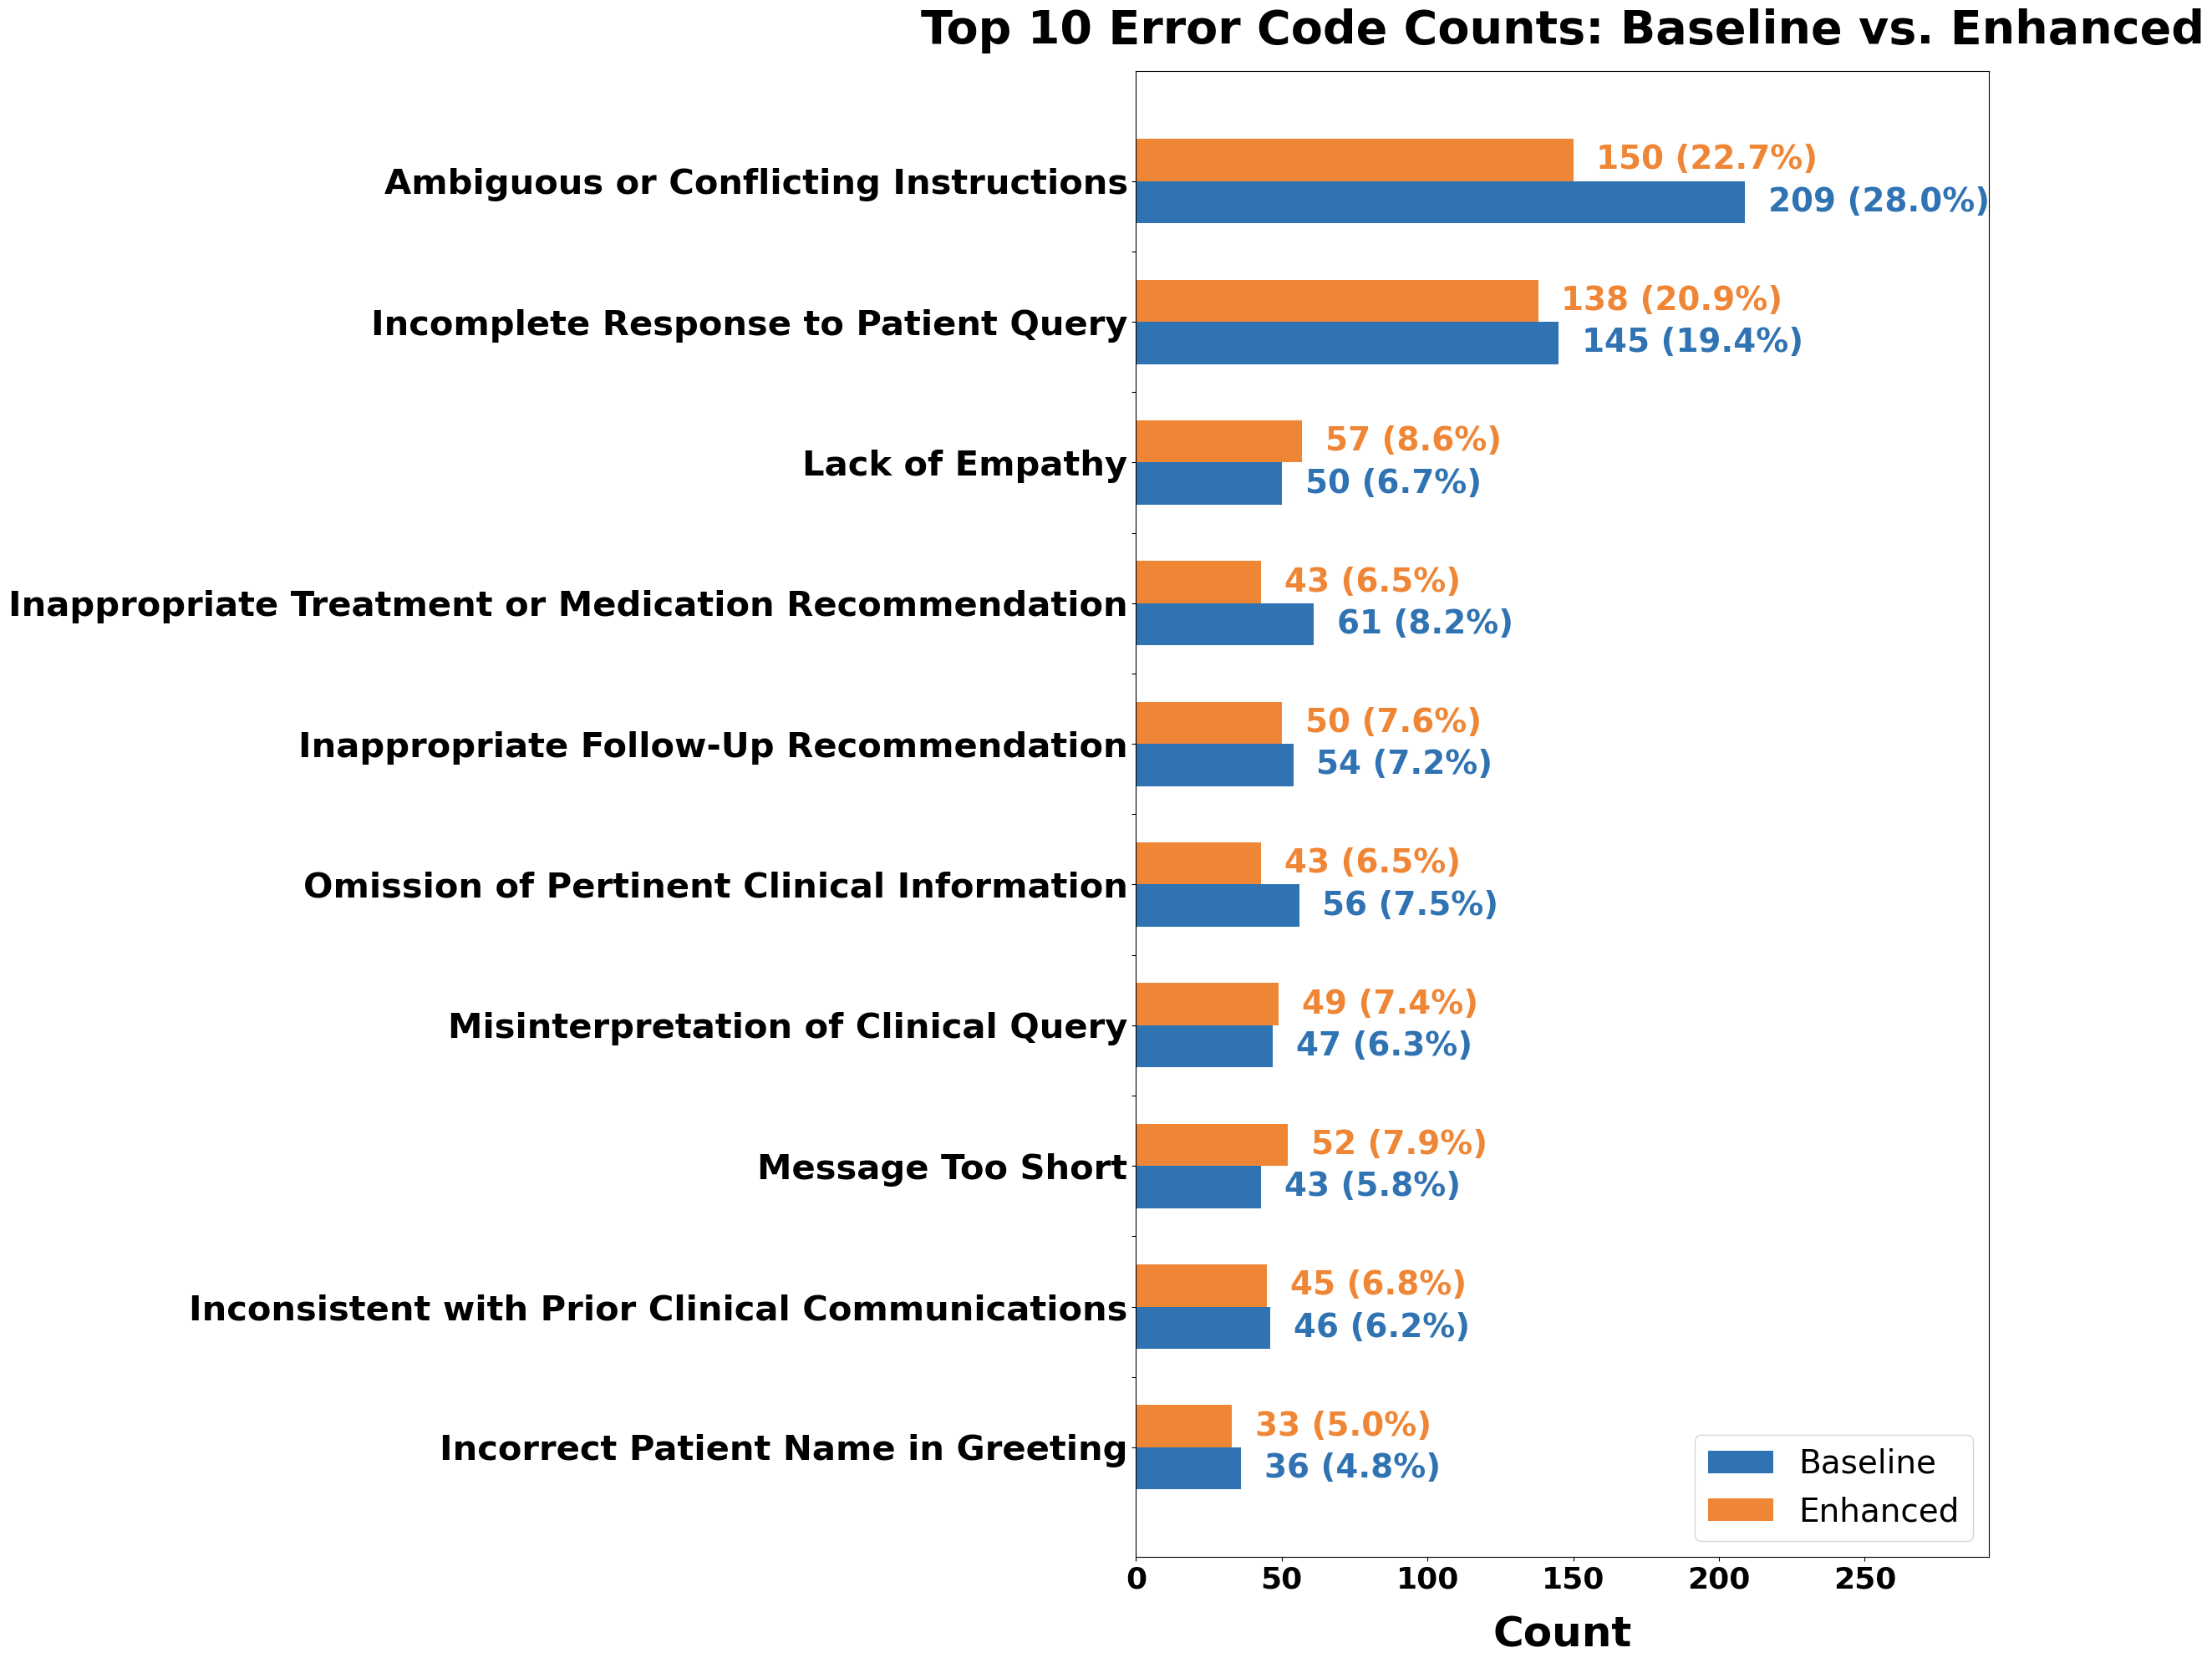

In [212]:
# def error_code_level_summary(df_full):
#     return (
#         df_full[df_full["has_error"] & df_full["error_code_yes"]]
#         .groupby(["domain", "subdomain", "error_code"])
#         .size()
#         .reset_index(name="count")
#     )

# errorcode_summary_baseline = error_code_level_summary(df_full_baseline)
# errorcode_summary_enhance  = error_code_level_summary(df_full_enhance)
# errorcode_comparison = errorcode_summary_baseline.merge(
#     errorcode_summary_enhance, 
#     on=["domain", "subdomain", "error_code"], 
#     how="outer", 
#     suffixes=('_baseline', '_enhanced')
# ).fillna(0)
# errorcode_comparison['total'] = errorcode_comparison['count_baseline'] + errorcode_comparison['count_enhanced']
# top_errorcodes = errorcode_comparison.sort_values('total', ascending=False).head(10)

# errorcode_comparison['delta'] = errorcode_comparison['count_enhanced'] - errorcode_comparison['count_baseline']

# codes = top_errorcodes['error_code'].tolist()
# # Insert blank spacers
# spaced_codes = []
# baseline_counts = []
# enhanced_counts = []
# for i, code in enumerate(codes):
#     spaced_codes.append(code)
#     baseline_counts.append(top_errorcodes['count_baseline'].iloc[i])
#     enhanced_counts.append(top_errorcodes['count_enhanced'].iloc[i])
#     # Add blank row after each real error code except the last one
#     if i < len(codes) - 1:
#         spaced_codes.append("")  # Blank label
#         baseline_counts.append(0)
#         enhanced_counts.append(0)

# x = np.arange(len(spaced_codes))
# width = 0.6

# # Calculate percentages for annotation
# total_baseline = top_errorcodes['count_baseline'].sum()
# total_enhanced = top_errorcodes['count_enhanced'].sum()
# baseline_pct = np.array(baseline_counts) / total_baseline * 100
# enhanced_pct = np.array(enhanced_counts) / total_enhanced * 100

# fig, ax = plt.subplots(figsize=(24, 20))

# rects1 = ax.barh(x - width/2, baseline_counts, width, label='Baseline', color='#3073b3')
# rects2 = ax.barh(x + width/2, enhanced_counts, width, label='Enhanced', color='#ef8636')

# ax.set_xlabel('Count', fontsize=36, fontweight='bold', labelpad=18)
# ax.set_title('Top 15 Error Code Counts: Baseline vs. Enhanced', fontsize=40, fontweight='bold', pad=24)
# ax.set_yticks(x)
# ax.set_yticklabels(spaced_codes, fontsize=30, fontweight='bold')
# ax.legend(fontsize=28, loc='best')

# # Add annotations (skip blank spacers)
# for i, (rect, pct) in enumerate(zip(rects1, baseline_pct)):
#     if spaced_codes[i] != "":
#         width_val = rect.get_width()
#         ax.annotate(
#             f'{int(width_val)} ({pct:.1f}%)',
#             xy=(width_val, rect.get_y() + rect.get_height() / 2),
#             xytext=(20, 0),
#             textcoords="offset points",
#             ha='left', va='center',
#             fontsize=28, fontweight='bold', color='#3073b3'
#         )
# for i, (rect, pct) in enumerate(zip(rects2, enhanced_pct)):
#     if spaced_codes[i] != "":
#         width_val = rect.get_width()
#         ax.annotate(
#             f'{int(width_val)} ({pct:.1f}%)',
#             xy=(width_val, rect.get_y() + rect.get_height() / 2),
#             xytext=(20, 0),
#             textcoords="offset points",
#             ha='left', va='center',
#             fontsize=28, fontweight='bold', color='#ef8636'
#         )

# plt.xticks(fontsize=26, fontweight='bold')
# plt.yticks(fontsize=30, fontweight='bold')
# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def error_code_level_summary(df_full):
    return (
        df_full[df_full["has_error"] & df_full["error_code_yes"]]
        .groupby(["domain", "subdomain", "error_code"])
        .size()
        .reset_index(name="count")
    )

# Example data loading (replace with your actual DataFrame variables)
# df_full_baseline = ...
# df_full_enhance = ...

errorcode_summary_baseline = error_code_level_summary(df_full_baseline)
errorcode_summary_enhance  = error_code_level_summary(df_full_enhance)

errorcode_comparison = errorcode_summary_baseline.merge(
    errorcode_summary_enhance, 
    on=["domain", "subdomain", "error_code"], 
    how="outer", 
    suffixes=('_baseline', '_enhanced')
).fillna(0)

errorcode_comparison['total'] = errorcode_comparison['count_baseline'] + errorcode_comparison['count_enhanced']
errorcode_comparison['delta'] = errorcode_comparison['count_enhanced'] - errorcode_comparison['count_baseline']

# Get top error codes by total
top_errorcodes = errorcode_comparison.sort_values('total', ascending=False).head(10)

codes = top_errorcodes['error_code'].tolist()
baseline_counts = top_errorcodes['count_baseline'].tolist()
enhanced_counts = top_errorcodes['count_enhanced'].tolist()

# Insert blank spacers between bars for readability
spaced_codes = []
spaced_baseline = []
spaced_enhanced = []
for i, code in enumerate(codes):
    spaced_codes.append(code)
    spaced_baseline.append(baseline_counts[i])
    spaced_enhanced.append(enhanced_counts[i])
    if i < len(codes) - 1:
        spaced_codes.append("")         # Blank label
        spaced_baseline.append(0)
        spaced_enhanced.append(0)

# REVERSE lists to put the longest bar at the top
spaced_codes = spaced_codes[::-1]
spaced_baseline = spaced_baseline[::-1]
spaced_enhanced = spaced_enhanced[::-1]

x = np.arange(len(spaced_codes))
width = 0.6

# Calculate percentages for annotation
total_baseline = sum(baseline_counts)
total_enhanced = sum(enhanced_counts)
baseline_pct = np.array(spaced_baseline) / total_baseline * 100
enhanced_pct = np.array(spaced_enhanced) / total_enhanced * 100

fig, ax = plt.subplots(figsize=(24, 20))

rects1 = ax.barh(x - width/2, spaced_baseline, width, label='Baseline', color='#3073b3')
rects2 = ax.barh(x + width/2, spaced_enhanced, width, label='Enhanced', color='#ef8636')

ax.set_xlabel('Count', fontsize=36, fontweight='bold', labelpad=18)
ax.set_title('Top 10 Error Code Counts: Baseline vs. Enhanced', fontsize=40, fontweight='bold', pad=24)
ax.set_yticks(x)
ax.set_yticklabels(spaced_codes, fontsize=30, fontweight='bold')
ax.legend(fontsize=28, loc='best')

# Add count + percent annotations (skip blank spacers)
for i, (rect, pct) in enumerate(zip(rects1, baseline_pct)):
    if spaced_codes[i] != "":
        width_val = rect.get_width()
        ax.annotate(
            f'{int(width_val)} ({pct:.1f}%)',
            xy=(width_val, rect.get_y() + rect.get_height() / 2),
            xytext=(20, 0),
            textcoords="offset points",
            ha='left', va='center',
            fontsize=28, fontweight='bold', color='#3073b3'
        )
for i, (rect, pct) in enumerate(zip(rects2, enhanced_pct)):
    if spaced_codes[i] != "":
        width_val = rect.get_width()
        ax.annotate(
            f'{int(width_val)} ({pct:.1f}%)',
            xy=(width_val, rect.get_y() + rect.get_height() / 2),
            xytext=(20, 0),
            textcoords="offset points",
            ha='left', va='center',
            fontsize=28, fontweight='bold', color='#ef8636'
        )

plt.xticks(fontsize=26, fontweight='bold')
plt.yticks(fontsize=30, fontweight='bold')
# Give more space on the right for the annotation text
# plt.subplots_adjust(right=10) 
# Optionally: add even more space dynamically if your bars/annotations are huge
max_bar = max([rect.get_width() for rect in rects1] + [rect.get_width() for rect in rects2])
plt.xlim(0, max_bar * 1.4)
plt.tight_layout()
plt.show()


In [16]:
df_full_baseline_merged = df_full_baseline.merge(cleaned_raw, on="index")
df_full_baseline_merged["adapted"] = (df_full_baseline_merged["QuickAction Executed"] == 20000)
df_full_enhance_merged = df_full_enhance.merge(cleaned_raw, on="index")
df_full_enhance_merged["adapted"] = (df_full_enhance_merged["QuickAction Executed"] == 20000)


In [17]:
import matplotlib.pyplot as plt

def plot_adaptation_delta_side_by_side_independent_topN(
    df1, df2,
    group_col="subdomain",
    df1_label="Enhanced",
    df2_label="Baseline",
    xlim=(-15, 15),
    font_scale=1.1,
    top_n=5,
    case_id_col="index",
    count_method="majority"  # "all", "majority", "first"
):
    def get_topN_sorted_delta(df, group_col, top_n, count_method):
        df_errors = df[df['error_code_yes']]
        use_all = (group_col == "error_code") or (count_method == "all")
        if use_all:
            # Use all error occurrences (standard behavior for error_code)
            error_counts = (
                df_errors
                .groupby(['adapted', group_col])
                .size()
                .reset_index(name='count')
            )
        elif count_method == "majority":
            # Use majority per case
            group_counts = (
                df_errors
                .groupby([case_id_col, group_col])
                .size()
                .reset_index(name='n')
            )
            group_counts = group_counts.sort_values([case_id_col, 'n'], ascending=[True, False])
            majority_group = group_counts.groupby(case_id_col).first().reset_index()
            # Merge adapted column
            adapted_map = df[[case_id_col, 'adapted']].drop_duplicates().set_index(case_id_col)['adapted']
            majority_group['adapted'] = majority_group[case_id_col].map(adapted_map)
            error_counts = (
                majority_group
                .groupby(['adapted', group_col])
                .size()
                .reset_index(name='count')
            )
        elif count_method == "first":
            # Use first error per case
            first_group = (
                df_errors
                .sort_values([case_id_col])
                .groupby(case_id_col)
                .first()
                .reset_index()
            )
            # Merge adapted column if not present
            if 'adapted' not in first_group.columns:
                adapted_map = df[[case_id_col, 'adapted']].drop_duplicates().set_index(case_id_col)['adapted']
                first_group['adapted'] = first_group[case_id_col].map(adapted_map)
            error_counts = (
                first_group
                .groupby(['adapted', group_col])
                .size()
                .reset_index(name='count')
            )
        else:
            raise ValueError("count_method must be 'all', 'majority', or 'first'.")

        error_pivot = error_counts.pivot(index=group_col, columns='adapted', values='count').fillna(0)
        error_pivot.columns = ['Not Adapted', 'Adapted'] if False in error_pivot.columns else error_pivot.columns
        col_sums = error_pivot.sum(axis=0)
        error_pct = error_pivot.divide(col_sums, axis=1) * 100
        if 'Adapted' in error_pct.columns and 'Not Adapted' in error_pct.columns:
            delta = error_pct['Adapted'] - error_pct['Not Adapted']
        else:
            delta = error_pct.iloc[:, 0]
        top_delta = delta.reindex(delta.abs().sort_values(ascending=False).index).head(top_n)
        return top_delta.sort_values(ascending=False)

    delta1 = get_topN_sorted_delta(df1, group_col, top_n, count_method)
    delta2 = get_topN_sorted_delta(df2, group_col, top_n, count_method)
    colors1 = ['#ef8636' if d > 0 else '#3073b3' for d in delta1]
    colors2 = ['#ef8636' if d > 0 else '#3073b3' for d in delta2]

    fig, axes = plt.subplots(1, 2, figsize=(24, 12), sharey=False)

    for ax, delta, colors, label in zip(axes, [delta1, delta2], [colors1, colors2], [df1_label, df2_label]):
        bars = ax.barh(delta.index, delta.values, color=colors)
        ax.axvline(0, color='gray', linestyle='--')
        ax.set_title(f'{label} ({group_col.capitalize()})', fontsize=int(28*font_scale), fontweight='bold', pad=int(16*font_scale))
        ax.set_xlabel("Δ % Points (Adapted - Not Adapted)", fontsize=int(22*font_scale), fontweight='bold')
        ax.set_xlim(xlim)
        ax.tick_params(axis='y', labelsize=int(20*font_scale))
        ax.tick_params(axis='x', labelsize=int(18*font_scale))
        for bar in bars:
            width = bar.get_width()
            if abs(width) > 0.1:
                xpos = width + (0.25 if width > 0 else -0.25)
                ha = 'left' if width > 0 else 'right'
                ax.text(
                    xpos,
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}%',
                    va='center',
                    ha=ha,
                    fontsize=int(16*font_scale), fontweight='bold'
                )
    fig.suptitle(
        f"Effect of Adaptation on {group_col.capitalize()} Distribution (Top {top_n} Shifts per Panel, count_method='{count_method}')",
        fontsize=int(34*font_scale), fontweight='bold', y=1.06
    )
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


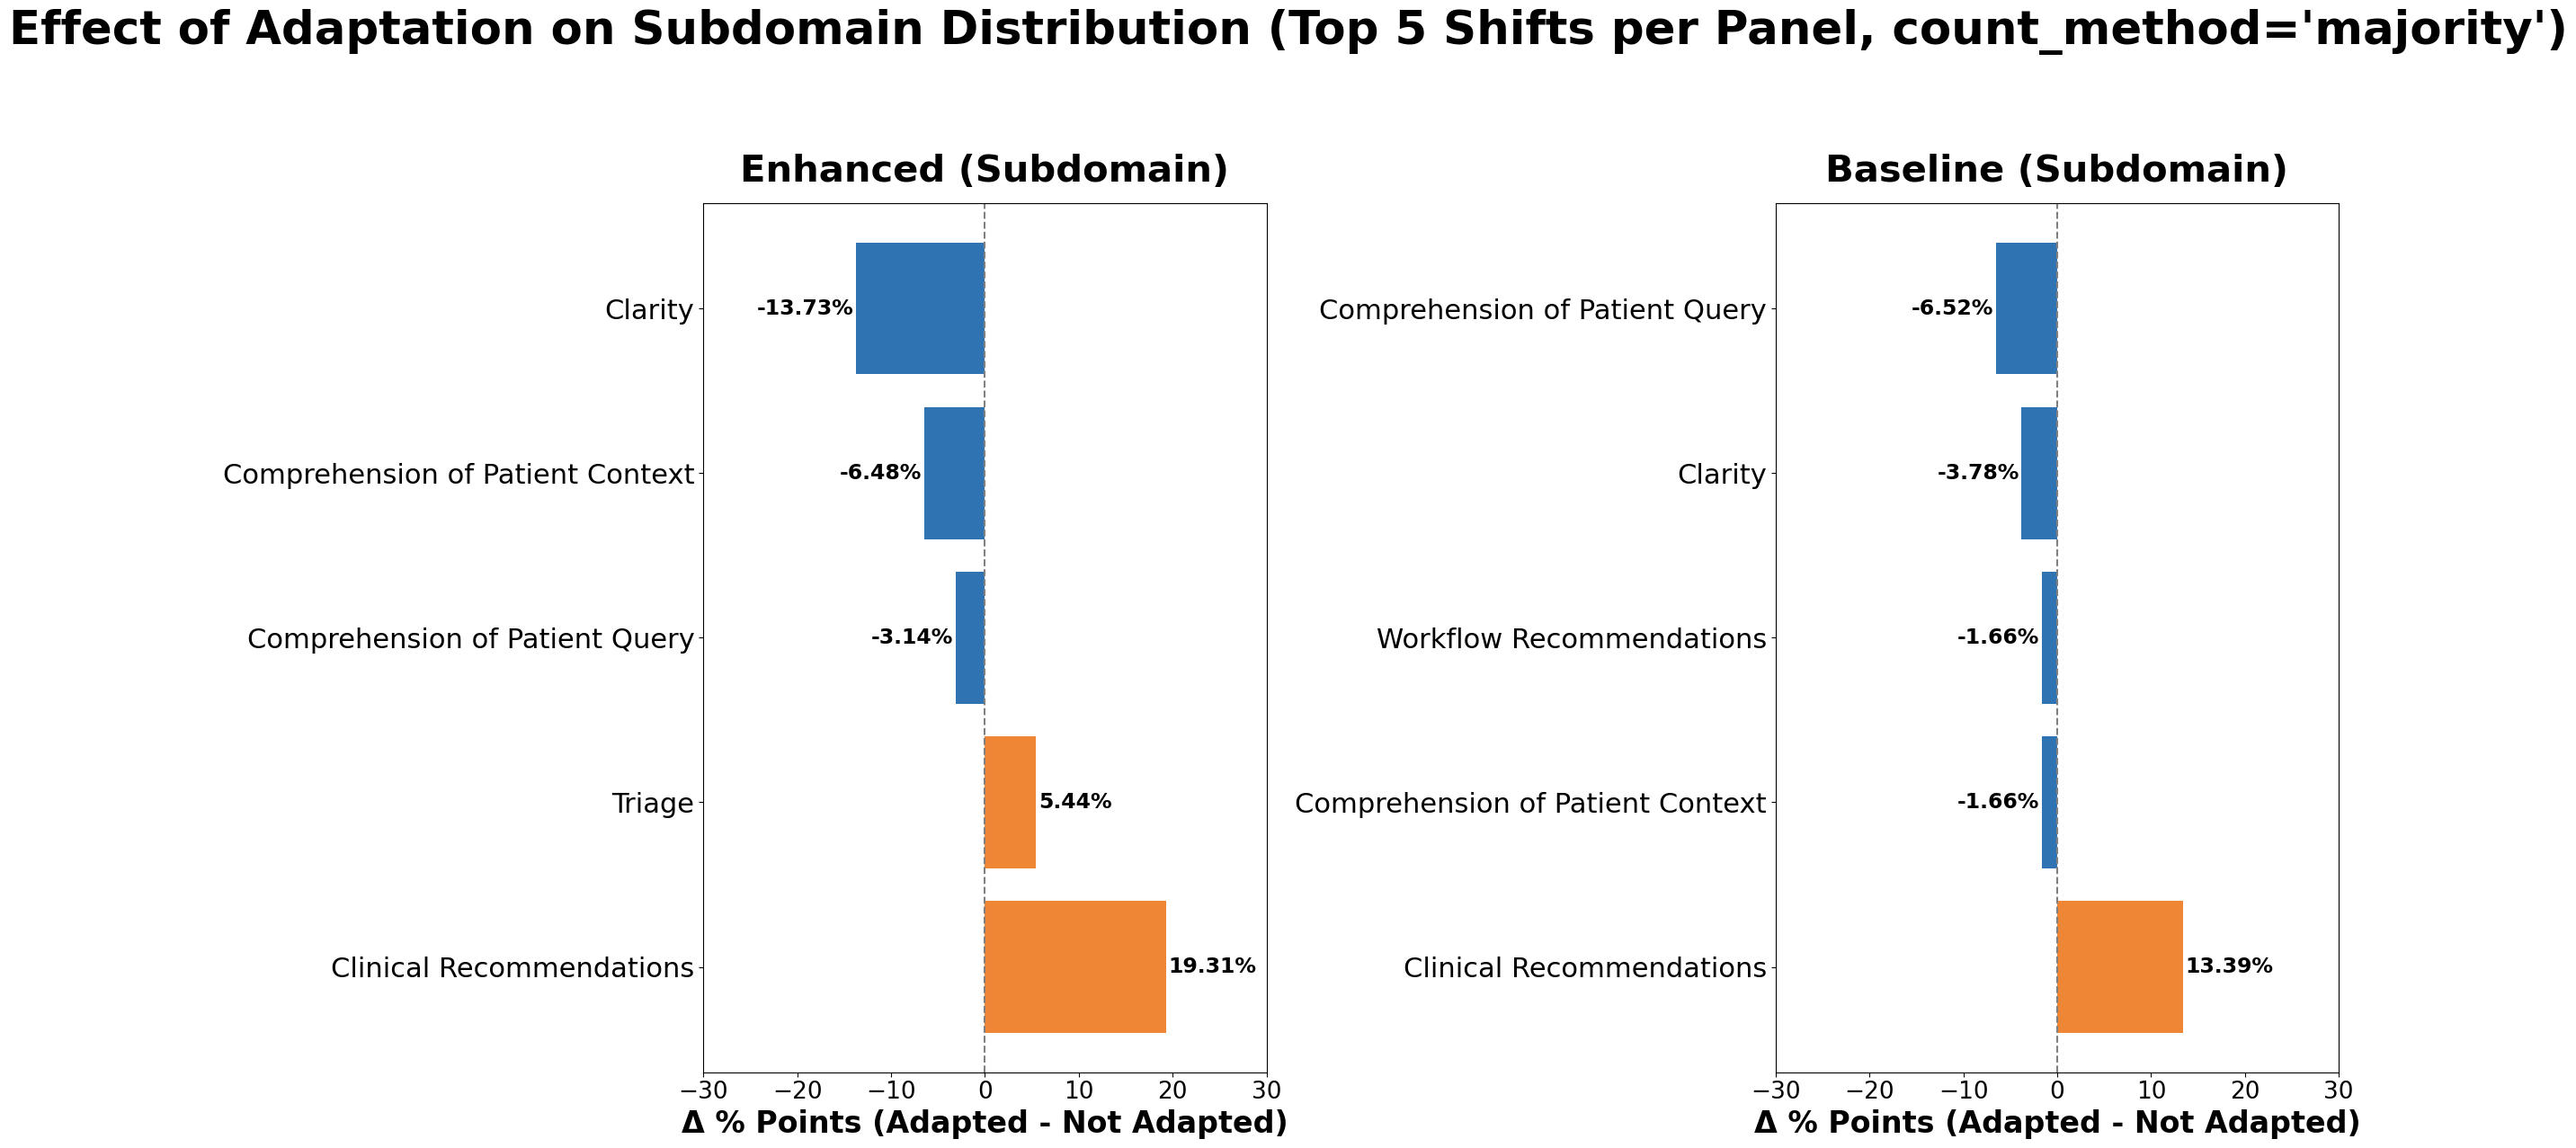

In [18]:
plot_adaptation_delta_side_by_side_independent_topN(
    df_full_enhance_merged, df_full_baseline_merged,
    group_col="subdomain",
    count_method="majority",
    top_n=5,
    xlim = (-30, 30)
)


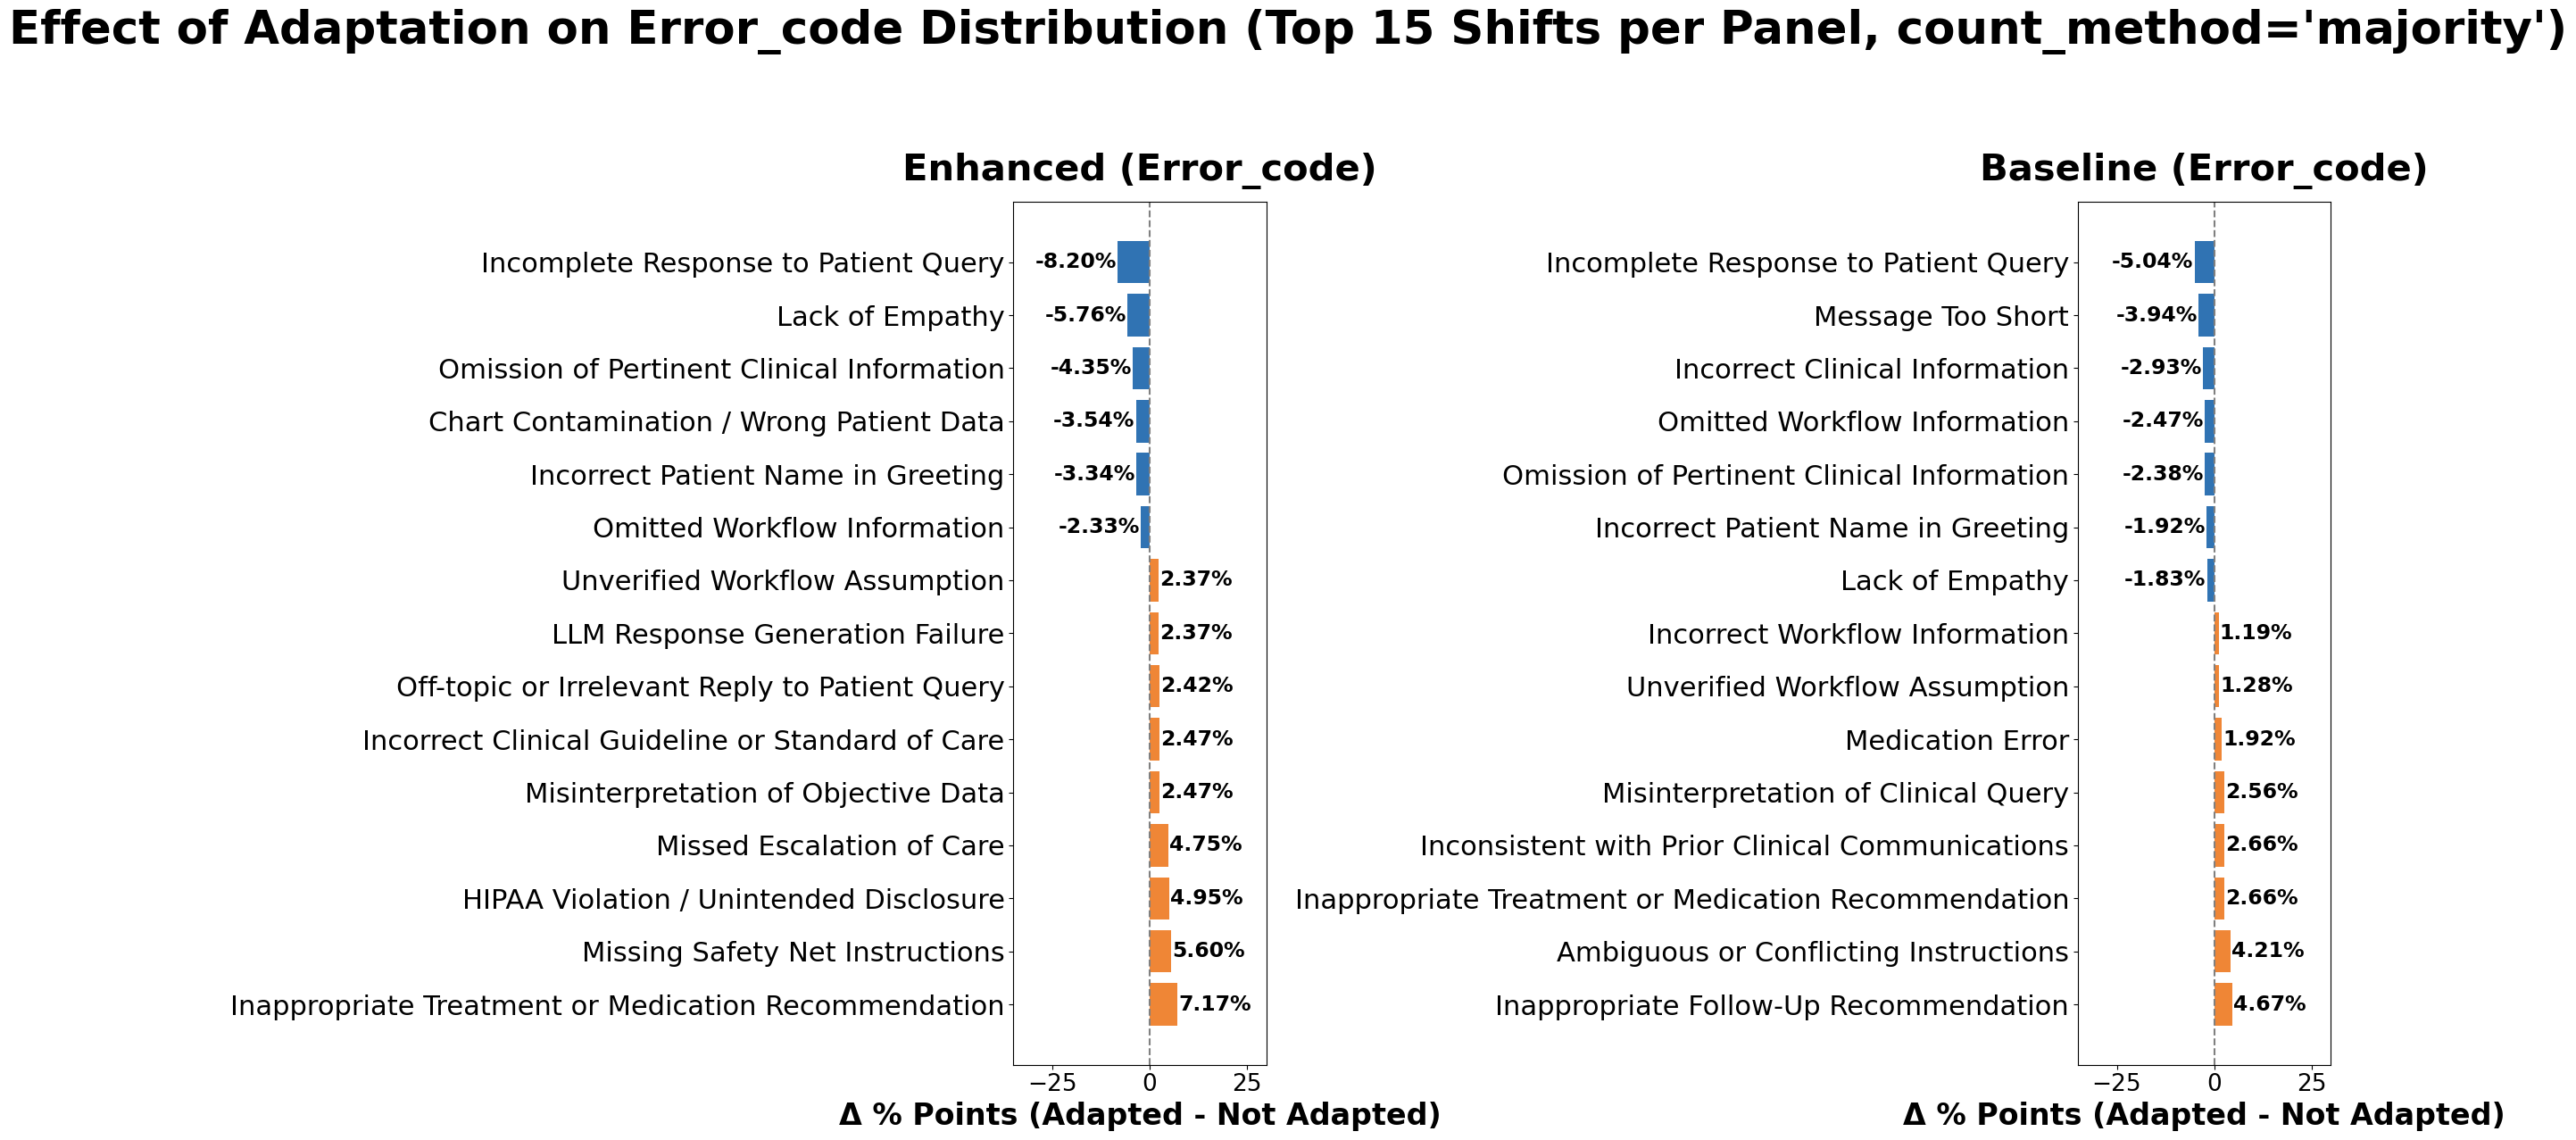

In [19]:
plot_adaptation_delta_side_by_side_independent_topN(
    df_full_enhance_merged, df_full_baseline_merged,
    group_col="error_code",
    count_method="majority",
    top_n=15,
    xlim = (-35, 30)
)


In [29]:
# def plot_adaptation_grouped_bar_with_number_legend(
#     df,
#     group_col="subdomain",
#     top_n=12,
#     font_scale=1.2,
#     figsize=(22, 10),
# ):
#     df_errors = df[df['error_code_yes'] == True].copy()

#     # Counts for Adapted and Not Adapted
#     counts = df_errors.groupby([group_col, 'adapted']).size().unstack(fill_value=0)
#     for col in [True, False]:
#         if col not in counts.columns:
#             counts[col] = 0

#     # Percent for annotation (of all Adapted/Not Adapted among all categories)
#     total_adapted = counts[True].sum()
#     total_notadapted = counts[False].sum()
#     pct_adapted = (counts[True] / total_adapted * 100).round(1) if total_adapted > 0 else np.zeros_like(counts[True])
#     pct_notadapted = (counts[False] / total_notadapted * 100).round(1) if total_notadapted > 0 else np.zeros_like(counts[False])
#     pct_diff = pct_adapted - pct_notadapted

#     # --- Sort by delta ---
#     sorted_idx = pct_diff.sort_values(ascending=False).index[:top_n]

#     # Number labels for x-axis and legend
#     label_nums = [str(i+1) for i in range(len(sorted_idx))]
#     label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

#     # Prepare data for plot
#     counts_plot = counts.reindex(sorted_idx, fill_value=0)
#     pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
#     pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
#     pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

#     notadapted = counts_plot[False].values
#     adapted = counts_plot[True].values
#     ind = np.arange(len(label_nums))
#     width = 0.35

#     fig, ax = plt.subplots(figsize=figsize)
#     bars_na = ax.bar(ind - width/2, notadapted, width, label='Not Adapted', color='#3073b3')
#     bars_ad = ax.bar(ind + width/2, adapted, width, label='Adapted', color='#ef8636')

#     count_font = int(15 * font_scale)
#     delta_font = int(19 * font_scale)

#     # Annotate counts and deltas
#     for i, (rect_na, rect_ad) in enumerate(zip(bars_na, bars_ad)):
#         # Not Adapted count (blue)
#         ax.annotate(
#             f"{int(rect_na.get_height())}",
#             xy=(rect_na.get_x() + rect_na.get_width() / 2, rect_na.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=count_font, color='#3073b3', fontweight='bold'
#         )
#         # Adapted count (orange)
#         ax.annotate(
#             f"{int(rect_ad.get_height())}",
#             xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=count_font, color='#ef8636', fontweight='bold'
#         )
#         # Delta percent centered between bars, just above the taller bar
#         y_top = max(rect_na.get_height(), rect_ad.get_height())
#         ax.annotate(
#             f"{pct_diff_plot.iloc[i]:+,.1f}%",
#             xy=(ind[i], y_top),
#             xytext=(0, 22), textcoords='offset points',
#             ha='center', va='bottom',
#             fontsize=delta_font, color='black', fontweight='bold'
#         )

#     y_max_bar = max(np.concatenate([notadapted, adapted])) if (len(notadapted) and len(adapted)) else 1
#     ax.set_ylim(top=y_max_bar * 1.22 + 10)

#     ax.set_ylabel('Count', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
#     ax.set_xticks(ind)
#     ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
#     ax.set_title(
#         f"Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} Delta %)\n"
#         "(Counts on bars; Δ% above: Adapted - Not Adapted, sorted by delta)",
#         fontsize=int(22*font_scale), fontweight='bold', pad=18)
#     ax.legend(fontsize=int(15*font_scale), loc='upper right')
#     ax.tick_params(axis='y', labelsize=int(14*font_scale))

#     plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
#     plt.tight_layout()

#     # Draw legend of numbered labels
#     legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
#     plt.gcf().text(
#         0.99, 0.5, "Legend:\n\n" + legend_text,
#         va='center', ha='left',
#         fontsize=int(17*font_scale), fontweight='normal',
#         family="monospace",
#         bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
#         linespacing=1.35
#     )

#     plt.show()

# # Usage:
# # plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="error_code", top_n=15)
# # plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="subdomain", top_n=12)
import matplotlib.pyplot as plt
import numpy as np

def plot_adaptation_grouped_bar_with_number_legend(
    df,
    group_col="subdomain",
    top_n=12,
    font_scale=1.2,
    figsize=(22, 10),
):
    df_errors = df[df['error_code_yes'] == True].copy()

    # Counts for Adapted and Not Adapted
    counts = df_errors.groupby([group_col, 'adapted']).size().unstack(fill_value=0)
    for col in [True, False]:
        if col not in counts.columns:
            counts[col] = 0

    # Percent for annotation (of all Adapted/Not Adapted among all categories)
    total_adapted = counts[True].sum()
    total_notadapted = counts[False].sum()
    pct_adapted = (counts[True] / total_adapted * 100).round(1) if total_adapted > 0 else np.zeros_like(counts[True])
    pct_notadapted = (counts[False] / total_notadapted * 100).round(1) if total_notadapted > 0 else np.zeros_like(counts[False])
    pct_diff = pct_adapted - pct_notadapted

    # --- Sort by delta ---
    sorted_idx = pct_diff.sort_values(ascending=False).index[:top_n]

    # Number labels for x-axis and legend
    label_nums = [str(i+1) for i in range(len(sorted_idx))]
    label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

    # Prepare data for plot
    counts_plot = counts.reindex(sorted_idx, fill_value=0)
    pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
    pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
    pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

    adapted = counts_plot[True].values
    notadapted = counts_plot[False].values
    ind = np.arange(len(label_nums))
    width = 0.35

    fig, ax = plt.subplots(figsize=figsize)

    # Plot Adapted on the left and Not Adapted on the right
    bars_ad = ax.bar(ind - width/2, adapted, width, label='Adapted', color='#ef8636', zorder=2)
    bars_na = ax.bar(ind + width/2, notadapted, width, label='Not Adapted', color='#3073b3', zorder=1)

    count_font = int(15 * font_scale)
    delta_font = int(19 * font_scale)

    # Annotate counts and deltas
    for i, (rect_ad, rect_na) in enumerate(zip(bars_ad, bars_na)):
        # Adapted count (orange, left)
        ax.annotate(
            f"{int(rect_ad.get_height())}",
            xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=count_font, color='#ef8636', fontweight='bold'
        )
        # Not Adapted count (blue, right)
        ax.annotate(
            f"{int(rect_na.get_height())}",
            xy=(rect_na.get_x() + rect_na.get_width() / 2, rect_na.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=count_font, color='#3073b3', fontweight='bold'
        )
        # Delta percent centered between bars, just above the taller bar
        y_top = max(rect_na.get_height(), rect_ad.get_height())
        ax.annotate(
            f"{pct_diff_plot.iloc[i]:+,.1f}%",
            xy=(ind[i], y_top),
            xytext=(0, 22), textcoords='offset points',
            ha='center', va='bottom',
            fontsize=delta_font, color='black', fontweight='bold'
        )

    y_max_bar = max(np.concatenate([notadapted, adapted])) if (len(notadapted) and len(adapted)) else 1
    ax.set_ylim(top=y_max_bar * 1.22 + 10)

    ax.set_ylabel('Count', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
    ax.set_xticks(ind)
    ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
    ax.set_title(
        f"Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} Delta %)\n"
        "(Counts on bars; Δ% above: Adapted - Not Adapted, sorted by delta)",
        fontsize=int(22*font_scale), fontweight='bold', pad=18)
    ax.legend(fontsize=int(15*font_scale), loc='upper right')
    ax.tick_params(axis='y', labelsize=int(14*font_scale))

    plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
    plt.tight_layout()

    # Draw legend of numbered labels
    legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
    plt.gcf().text(
        0.99, 0.5, "Legend:\n\n" + legend_text,
        va='center', ha='left',
        fontsize=int(17*font_scale), fontweight='normal',
        family="monospace",
        bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
        linespacing=1.35
    )

    plt.show()

# Example usage:
# plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="error_code", top_n=15)
# plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="subdomain", top_n=12)


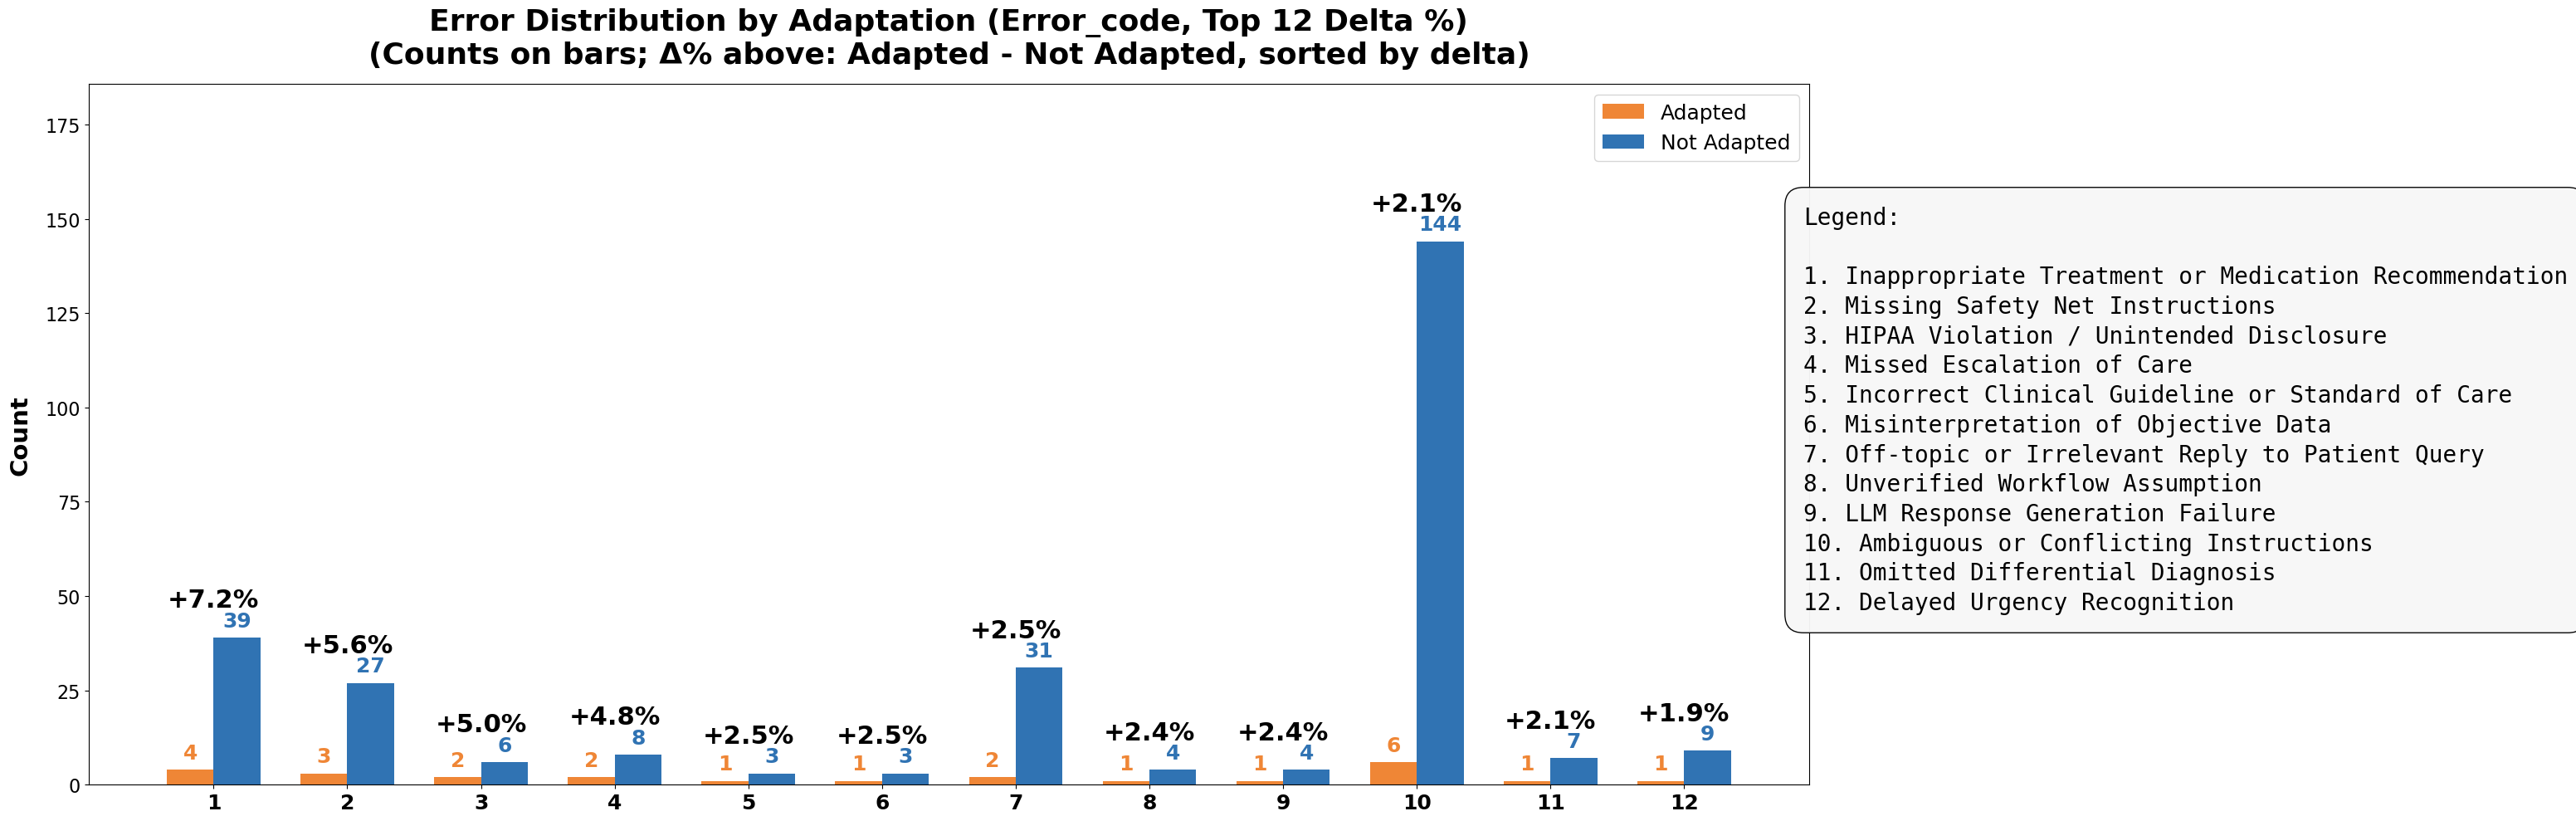

In [30]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="error_code", top_n=12)

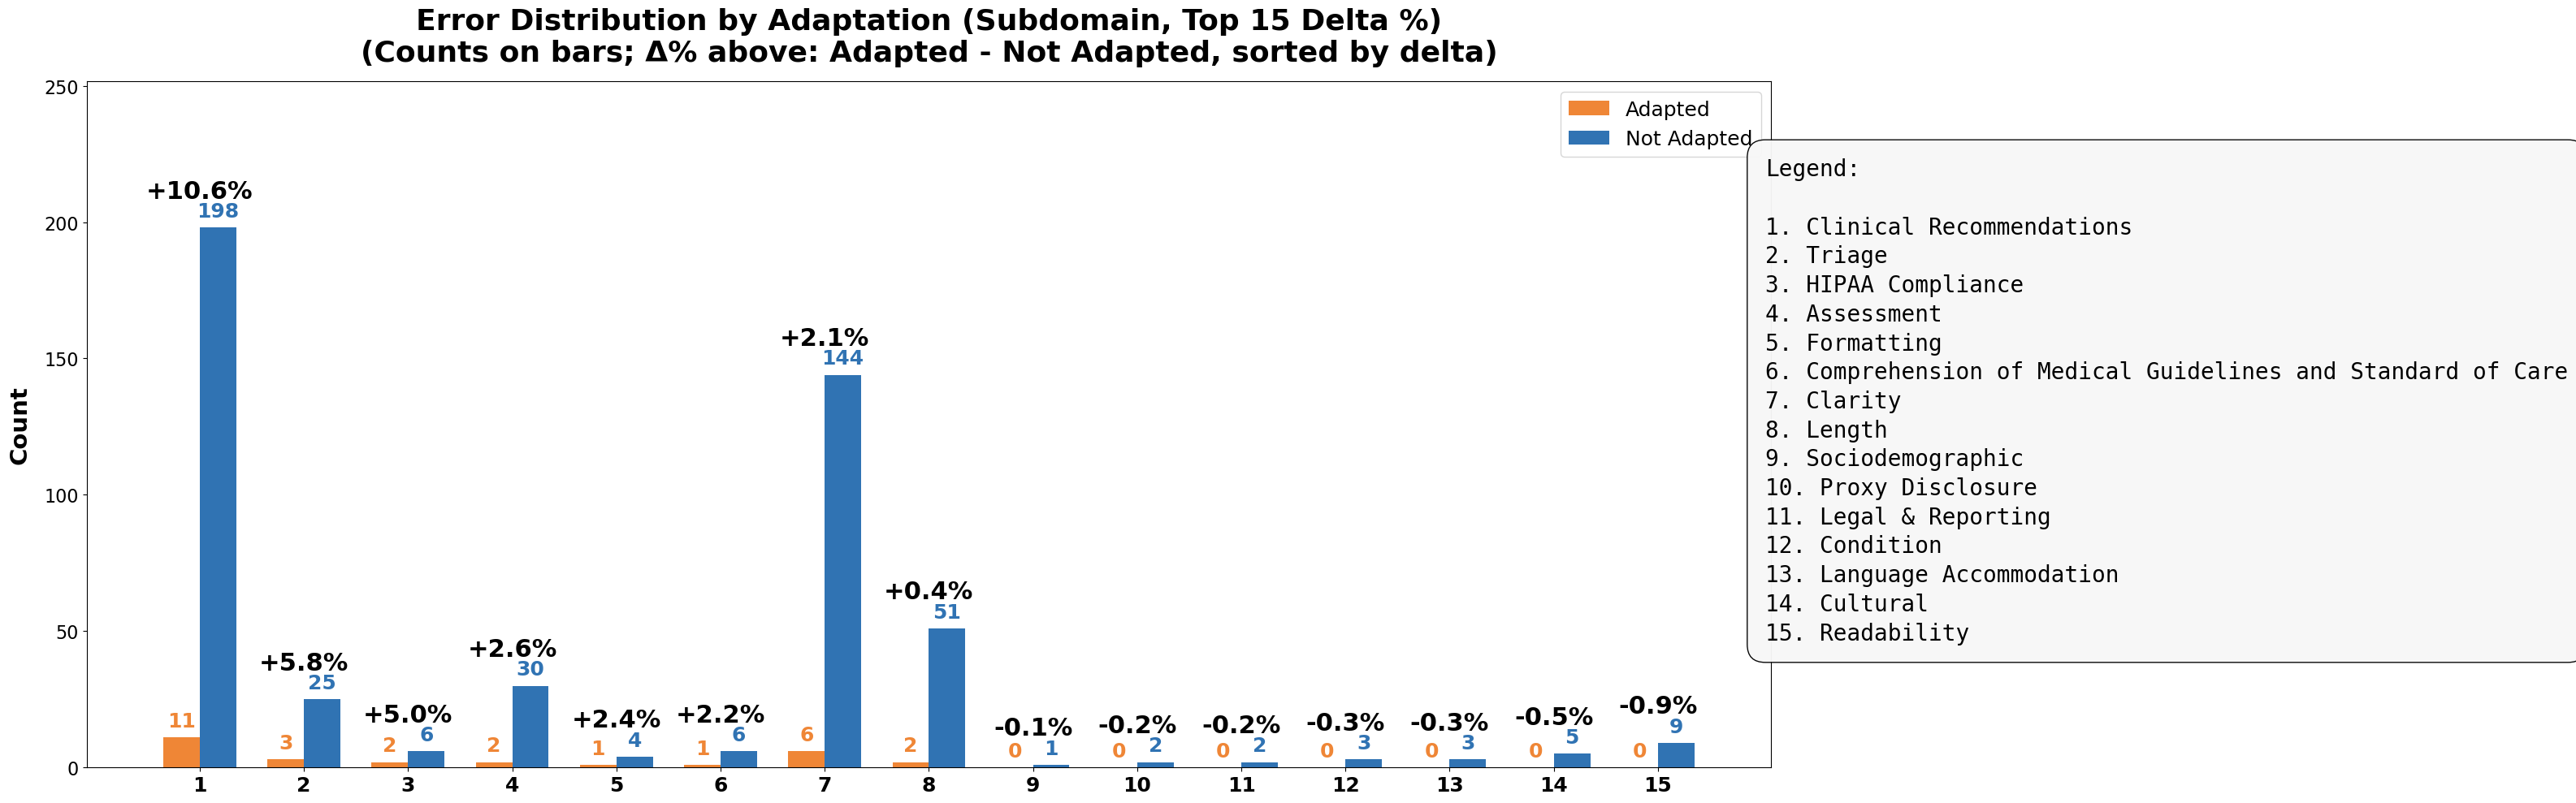

In [31]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="subdomain", top_n=15)

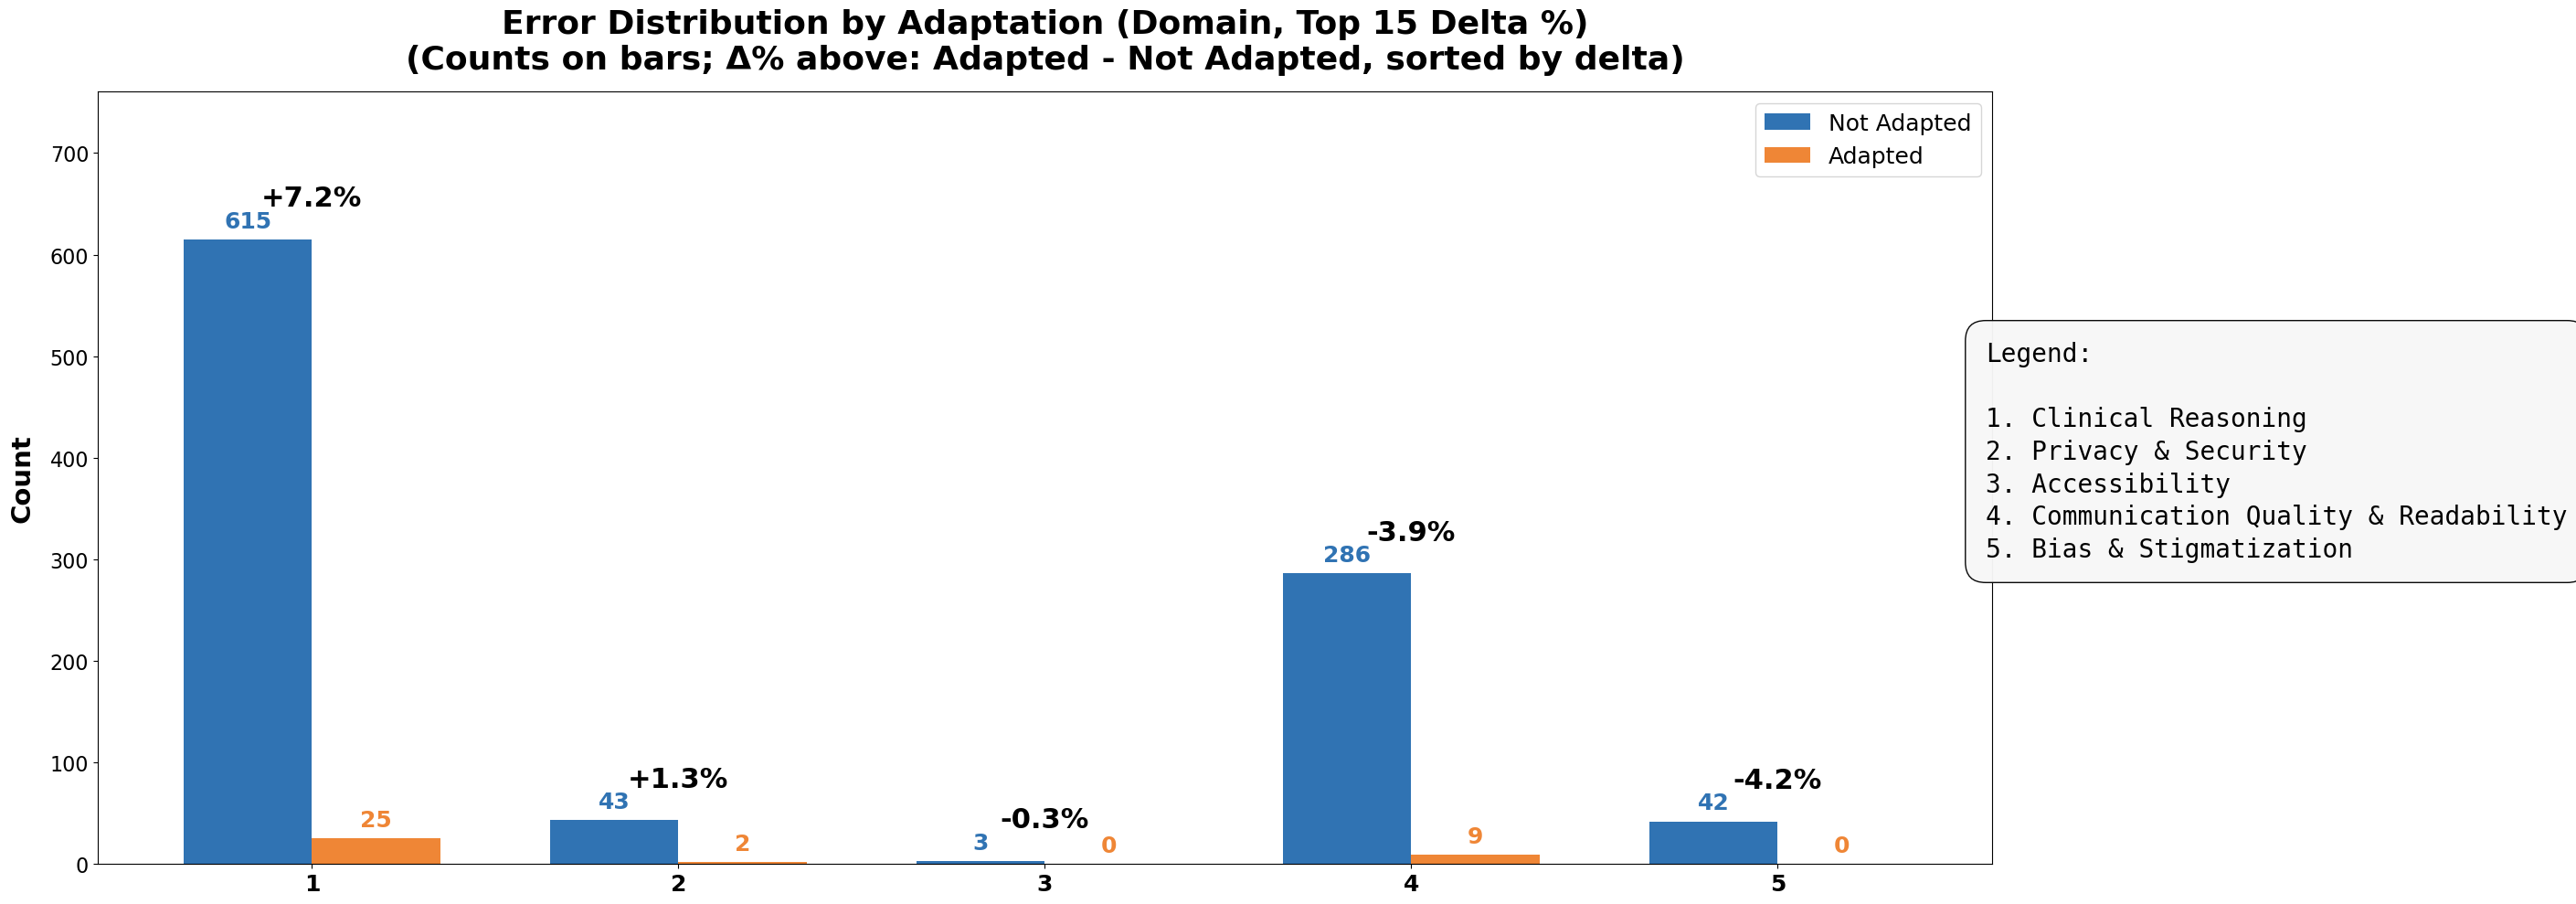

In [23]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="domain", top_n=15)

In [24]:
df_full_enhance_merged["index"].nunique()

1570

In [25]:
df_full_enhance_merged[df_full_enhance_merged["error_code_yes"]]["index"].nunique()

307

In [26]:
df_full_baseline_merged[df_full_baseline_merged["error_code_yes"]]["index"].nunique()

350

In [130]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_adaptation_grouped_bar_with_number_legend(
#     df,
#     group_col="subdomain",
#     top_n=12,
#     font_scale=1.2,
#     figsize=(22, 10),
# ):
#     df_errors = df[df['error_code_yes'] == True].copy()

#     # Counts for Adapted and Not Adapted
#     counts = df_errors.groupby([group_col, 'adapted']).size().unstack(fill_value=0)
#     for col in [True, False]:
#         if col not in counts.columns:
#             counts[col] = 0

#     total_adapted = counts[True].sum()
#     total_notadapted = counts[False].sum()
#     pct_adapted = (counts[True] / total_adapted * 100).round(1) if total_adapted > 0 else np.zeros_like(counts[True])
#     pct_notadapted = (counts[False] / total_notadapted * 100).round(1) if total_notadapted > 0 else np.zeros_like(counts[False])
#     pct_diff = pct_adapted - pct_notadapted

#     # --- Sort by delta ---
#     sorted_idx = pct_diff.sort_values(ascending=False).index[:top_n]
#     label_nums = [str(i+1) for i in range(len(sorted_idx))]
#     label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

#     pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
#     pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
#     counts_plot = counts.reindex(sorted_idx, fill_value=0)
#     pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

#     adapted_pct = pct_adapted_plot.values
#     notadapted_pct = pct_notadapted_plot.values
#     adapted_count = counts_plot[True].values
#     notadapted_count = counts_plot[False].values
#     ind = np.arange(len(label_nums))
#     width = 0.35

#     fig, ax = plt.subplots(figsize=figsize)
#     bars_ad = ax.bar(ind - width/2, adapted_pct, width, label='Draft Used', color='#ef8636', zorder=2)
#     bars_na = ax.bar(ind + width/2, notadapted_pct, width, label='Draft Not Used', color='#3073b3', zorder=1)

#     percent_font = int(15 * font_scale)
#     delta_font = int(20 * font_scale)
#     fraction_font = int(19 * font_scale)

#     # Annotate delta % at top of each group (extra space)
#     for i in range(len(ind)):
#         y_top = max(adapted_pct[i], notadapted_pct[i])
#         ax.annotate(
#             f"{pct_diff_plot.iloc[i]:+,.1f}%",
#             xy=(ind[i], y_top),
#             xytext=(0, 32), textcoords='offset points',
#             ha='center', va='bottom',
#             fontsize=delta_font, color='black', fontweight='bold'
#         )

#     # Annotate percentages at the top of each bar and fractions (math style, end of bar)
#     for i, (rect_ad, rect_na) in enumerate(zip(bars_ad, bars_na)):
#         # Adapted bar (left)
#         ax.annotate(
#             f"{adapted_pct[i]:.1f}%",
#             xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=percent_font, color='#ef8636', fontweight='bold'
#         )
#         # Math fraction annotation (adapted)
#         fraction_str_ad = fr'$\frac{{{adapted_count[i]}}}{{{total_adapted}}}$'
#         ax.annotate(
#             fraction_str_ad,
#             xy=(rect_ad.get_x() + rect_ad.get_width(), rect_ad.get_height()),
#             xytext=(-2, -6), textcoords='offset points',
#             ha='right', va='top', fontsize=fraction_font, color='white', fontweight='bold'
#         )

#         # Not Adapted bar (right)
#         ax.annotate(
#             f"{notadapted_pct[i]:.1f}%",
#             xy=(rect_na.get_x() + rect_na.get_width() / 2, rect_na.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=percent_font, color='#3073b3', fontweight='bold'
#         )
#         # Math fraction annotation (not adapted)
#         fraction_str_na = fr'$\frac{{{notadapted_count[i]}}}{{{total_notadapted}}}$'
#         ax.annotate(
#             fraction_str_na,
#             xy=(rect_na.get_x() + rect_na.get_width(), rect_na.get_height()),
#             xytext=(-2, -6), textcoords='offset points',
#             ha='right', va='top', fontsize=fraction_font, color='white', fontweight='bold'
#         )

#     y_max_bar = max(np.concatenate([adapted_pct, notadapted_pct])) if (len(adapted_pct) and len(notadapted_pct)) else 1
#     ax.set_ylim(top=y_max_bar * 1.22 + 10)

#     ax.set_ylabel('Percentage of Errors (%)', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
#     ax.set_xticks(ind)
#     ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
#     ax.set_title(
#         f"Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} Delta %)\n"
#         "(Bar: % of all errors in group; Δ% above: Draft Used - Draft Not Used, sorted by delta)",
#         fontsize=int(22*font_scale), fontweight='bold', pad=18)
#     ax.legend(fontsize=int(15*font_scale), loc='upper right')
#     ax.tick_params(axis='y', labelsize=int(14*font_scale))
#     plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
#     plt.tight_layout()

#     # Draw legend of numbered labels
#     legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
#     plt.gcf().text(
#         0.99, 0.5, "Legend:\n\n" + legend_text,
#         va='center', ha='left',
#         fontsize=int(17*font_scale), fontweight='normal',
#         family="monospace",
#         bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
#         linespacing=1.35
#     )

# #     plt.show()
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_adaptation_grouped_bar_with_number_legend(
#     df,
#     group_col="subdomain",
#     top_n=12,
#     font_scale=1.2,
#     figsize=(22, 10),
# ):
#     df_errors = df[df['error_code_yes'] == True].copy()

#     # Counts for Adapted and Not Adapted
#     counts = df_errors.groupby([group_col, 'adapted']).size().unstack(fill_value=0)
#     for col in [True, False]:
#         if col not in counts.columns:
#             counts[col] = 0

#     total_adapted = counts[True].sum()
#     total_notadapted = counts[False].sum()
#     pct_adapted = (counts[True] / total_adapted * 100).round(1) if total_adapted > 0 else np.zeros_like(counts[True])
#     pct_notadapted = (counts[False] / total_notadapted * 100).round(1) if total_notadapted > 0 else np.zeros_like(counts[False])
#     pct_diff = pct_adapted - pct_notadapted

#     # --- Sort by delta ---
#     sorted_idx = pct_diff.sort_values(ascending=False).index[:top_n]
#     label_nums = [str(i+1) for i in range(len(sorted_idx))]
#     label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

#     pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
#     pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
#     counts_plot = counts.reindex(sorted_idx, fill_value=0)
#     pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

#     adapted_pct = pct_adapted_plot.values
#     notadapted_pct = pct_notadapted_plot.values
#     adapted_count = counts_plot[True].values
#     notadapted_count = counts_plot[False].values
#     # ind = np.arange(len(label_nums))
#     ind = np.arange(len(label_nums)) * 1.8  # spread them out more
#     width = 0.8

#     fig, ax = plt.subplots(figsize=figsize)
#     bars_ad = ax.bar(ind - width/2, adapted_pct, width, label='Draft Used', color='#ef8636', zorder=2)
#     bars_na = ax.bar(ind + width/2, notadapted_pct, width, label='Draft Not Used', color='#3073b3', zorder=1)

#     percent_font = int(15 * font_scale)
#     delta_font = int(20 * font_scale)
#     fraction_font = int(10 * font_scale)

#     # Annotate delta % at top of each group
#     for i in range(len(ind)):
#         y_top = max(adapted_pct[i], notadapted_pct[i])
#         ax.annotate(
#             f"Δ:{pct_diff_plot.iloc[i]:+,.1f}",
#             xy=(ind[i], y_top  + 2),
#             xytext=(0, 12), textcoords='offset points',
#             ha='center', va='bottom',
#             fontsize=delta_font, color='black', fontweight='bold'
#         )

#     # Annotate percentages at the top of each bar and fractions inside bars
#     for i, (rect_ad, rect_na) in enumerate(zip(bars_ad, bars_na)):
#         # Adapted bar (left)
#         ax.annotate(
#             f"{adapted_pct[i]:.1f}%",
#             xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=percent_font, color='#ef8636', fontweight='bold'
#         )
#         ax.annotate(
#             f"{adapted_count[i]}/{total_adapted}",
#             xy=(rect_ad.get_x() + rect_ad.get_width() / 2, 0.03*rect_ad.get_height()),
#             ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
#         )
#         # Not Adapted bar (right)
#         ax.annotate(
#             f"{notadapted_pct[i]:.1f}%",
#             xy=(rect_na.get_x() + rect_na.get_width() / 2 + 0.06, rect_na.get_height()),
#             xytext=(0, 6), textcoords='offset points',
#             ha='center', va='bottom', fontsize=percent_font, color='#3073b3', fontweight='bold'
#         )
#         ax.annotate(
#             f"{notadapted_count[i]}/{total_notadapted}",
#             xy=(rect_na.get_x() + rect_na.get_width() / 2, 0.03*rect_na.get_height()),
#             ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
#         )

#     y_max_bar = max(np.concatenate([adapted_pct, notadapted_pct])) if (len(adapted_pct) and len(notadapted_pct)) else 1
#     ax.set_ylim(top=y_max_bar * 1.22 + 10)

#     ax.set_ylabel('Percentage of Errors (%)', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
#     # ax.set_ylim(0,20)
#     ax.set_xticks(ind)
#     ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
#     ax.set_title(
#         f"Enhanced: Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} Delta %)\n"
#         "(Bar: % of all errors in group; Δ% above: Draft Used - Draft Not Used, sorted by delta)",
#         fontsize=int(22*font_scale), fontweight='bold', pad=18)
#     ax.legend(fontsize=int(15*font_scale), loc='upper right')
#     ax.tick_params(axis='y', labelsize=int(14*font_scale))
#     plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
#     plt.tight_layout()

#     # Draw legend of numbered labels
#     legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
#     plt.gcf().text(
#         0.99, 0.5, "Legend:\n\n" + legend_text,
#         va='center', ha='left',
#         fontsize=int(17*font_scale), fontweight='normal',
#         family="monospace",
#         bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
#         linespacing=1.35
#     )

#     plt.show()

In [145]:
import matplotlib.pyplot as plt
import numpy as np

def plot_adaptation_grouped_bar_with_number_legend(
    df,
    group_col="subdomain",
    top_n=12,
    font_scale=1.2,
    figsize=(22, 10),
):
    # Filter to only error rows
    df_errors = df[df['error_code_yes'] == True].copy()

    # Compute counts for Adapted and Not Adapted
    counts = df_errors.groupby([group_col, 'adapted']).size().unstack(fill_value=0)
    for col in [True, False]:
        if col not in counts.columns:
            counts[col] = 0

    # Compute totals and percentages
    total_adapted = counts[True].sum()
    total_notadapted = counts[False].sum()
    pct_adapted = (counts[True] / total_adapted * 100).round(1) if total_adapted > 0 else np.zeros_like(counts[True])
    pct_notadapted = (counts[False] / total_notadapted * 100).round(1) if total_notadapted > 0 else np.zeros_like(counts[False])
    pct_diff = pct_adapted - pct_notadapted

    # --- Select top N by absolute difference ---
    top_idx = pct_diff.abs().sort_values(ascending=False).index[:top_n]
    top_diff = pct_diff.loc[top_idx]

    # Group: positives first (descending), then negatives (ascending)
    pos_idx = top_diff[top_diff >= 0].sort_values(ascending=False).index
    neg_idx = top_diff[top_diff < 0].sort_values(ascending=True).index
    sorted_idx = list(pos_idx) + list(neg_idx)

    label_nums = [str(i+1) for i in range(len(sorted_idx))]
    label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

    # Prepare data for plotting in the new order
    pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
    pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
    counts_plot = counts.reindex(sorted_idx, fill_value=0)
    pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

    adapted_pct = pct_adapted_plot.values
    notadapted_pct = pct_notadapted_plot.values
    adapted_count = counts_plot[True].values
    notadapted_count = counts_plot[False].values
    ind = np.arange(len(label_nums)) * 1.8  # spread out x positions
    width = 0.8

    # Start plotting
    fig, ax = plt.subplots(figsize=figsize)
    bars_ad = ax.bar(ind - width/2, adapted_pct, width, label='Draft Used', color='#ef8636', zorder=2)
    bars_na = ax.bar(ind + width/2, notadapted_pct, width, label='Draft Not Used', color='#3073b3', zorder=1)

    percent_font = int(15 * font_scale)
    delta_font = int(20 * font_scale)
    fraction_font = int(10 * font_scale)

    # Annotate delta % at top of each group
    for i in range(len(ind)):
        y_top = max(adapted_pct[i], notadapted_pct[i])
        ax.annotate(
            f"Δ:{pct_diff_plot.iloc[i]:+,.1f}",
            xy=(ind[i], y_top  + 2),
            xytext=(0, 12), textcoords='offset points',
            ha='center', va='bottom',
            fontsize=delta_font, color='black', fontweight='bold'
        )

    # Annotate percentages at top of each bar and fractions inside
    for i, (rect_ad, rect_na) in enumerate(zip(bars_ad, bars_na)):
        # Adapted bar (left)
        ax.annotate(
            f"{adapted_pct[i]:.1f}%",
            xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=percent_font, color='#ef8636', fontweight='bold'
        )
        ax.annotate(
            f"{adapted_count[i]}/{total_adapted}",
            xy=(rect_ad.get_x() + rect_ad.get_width() / 2, 0.03*rect_ad.get_height()),
            ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
        )
        # Not Adapted bar (right)
        ax.annotate(
            f"{notadapted_pct[i]:.1f}%",
            xy=(rect_na.get_x() + rect_na.get_width() / 2 + 0.06, rect_na.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=percent_font, color='#3073b3', fontweight='bold'
        )
        ax.annotate(
            f"{notadapted_count[i]}/{total_notadapted}",
            xy=(rect_na.get_x() + rect_na.get_width() / 2, 0.03*rect_na.get_height()),
            ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
        )

    y_max_bar = max(np.concatenate([adapted_pct, notadapted_pct])) if (len(adapted_pct) and len(notadapted_pct)) else 1
    ax.set_ylim(top=y_max_bar * 1.22 + 10)

    ax.set_ylabel('Percentage of Errors (%)', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
    ax.set_xticks(ind)
    ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
    ax.set_title(
        f"Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} Absolute Δ%, Grouped by Sign)\n"
        "(Bar: % of all errors in group; Δ% above: Draft Used - Draft Not Used, positive Δ% left, negative right)",
        fontsize=int(22*font_scale), fontweight='bold', pad=18)
    ax.legend(fontsize=int(15*font_scale), loc='upper right')
    ax.tick_params(axis='y', labelsize=int(14*font_scale))
    plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
    plt.tight_layout()

    # Draw legend of numbered labels
    legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
    plt.gcf().text(
        0.99, 0.5, "Legend:\n\n" + legend_text,
        va='center', ha='left',
        fontsize=int(17*font_scale), fontweight='normal',
        family="monospace",
        bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
        linespacing=1.35
    )

    plt.show()


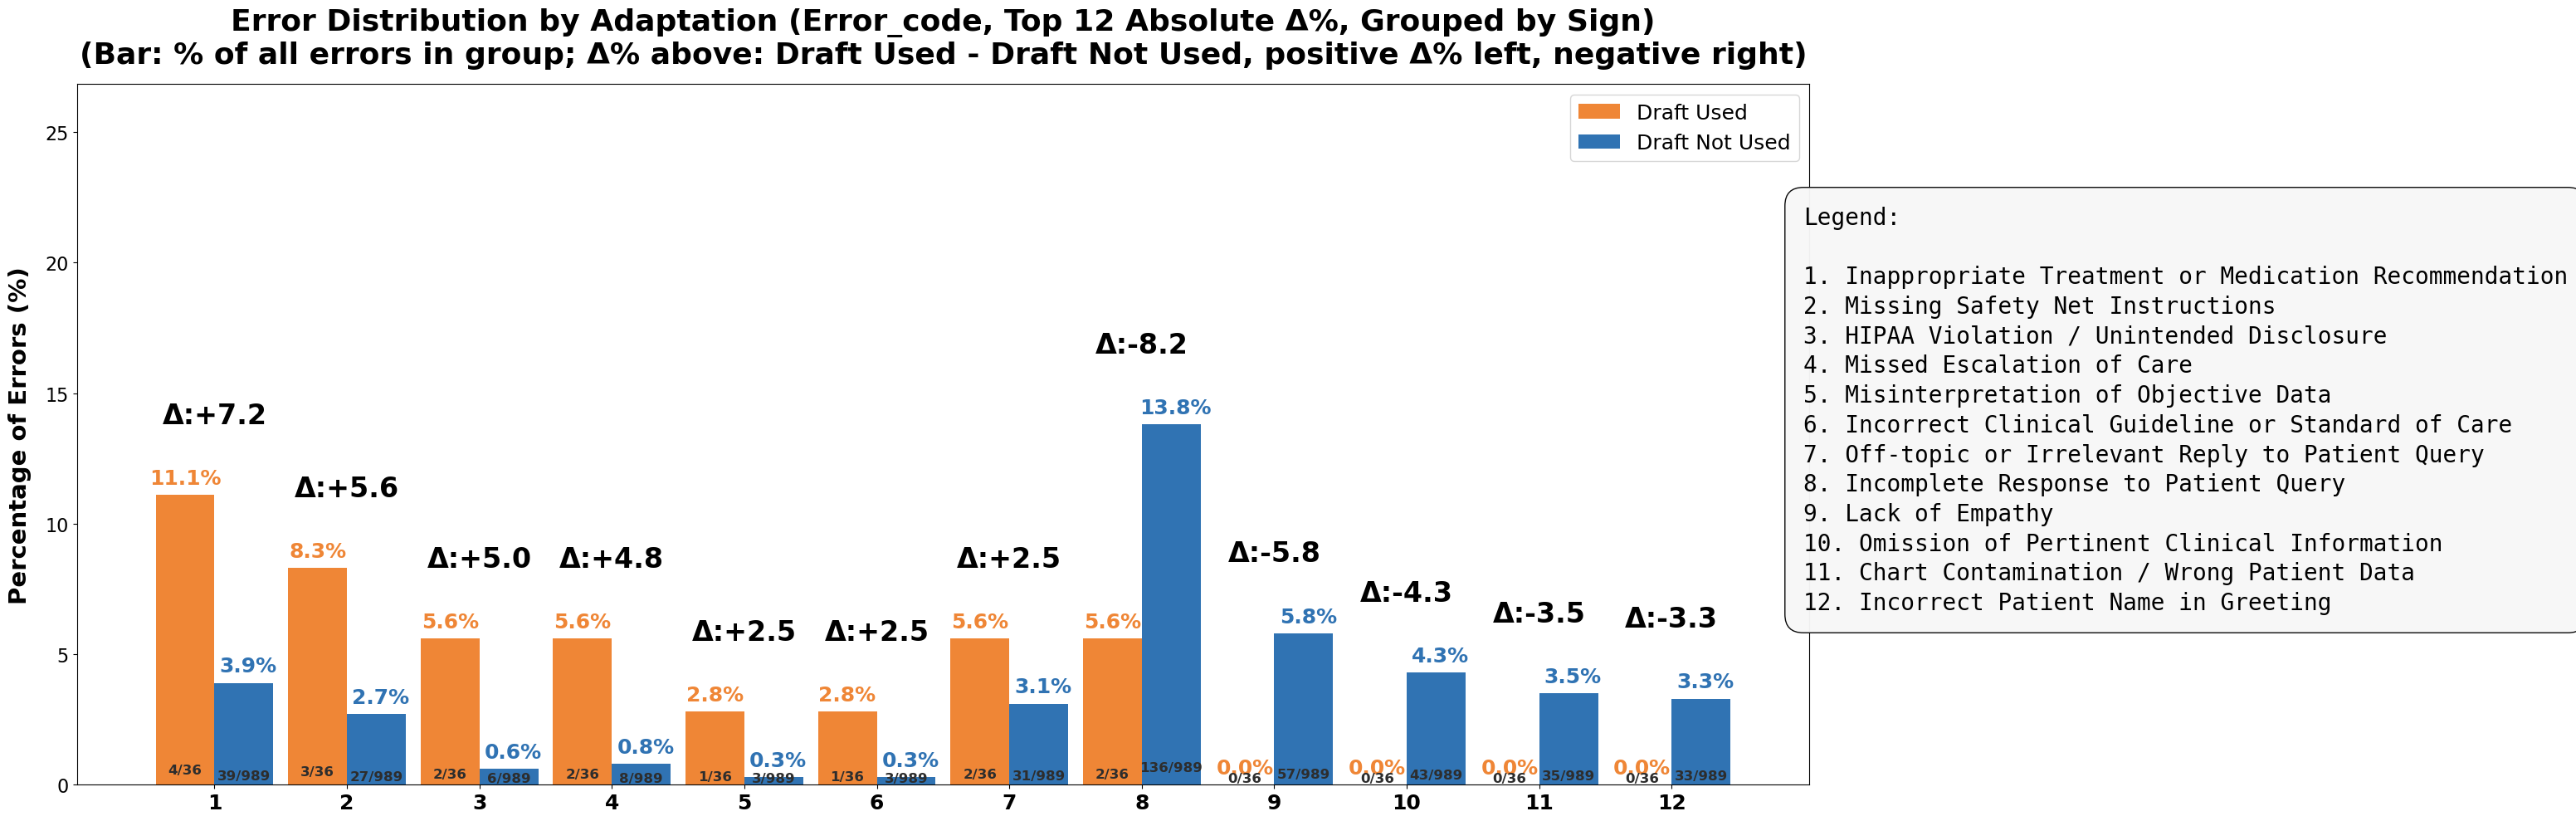

In [146]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="error_code", top_n=12)

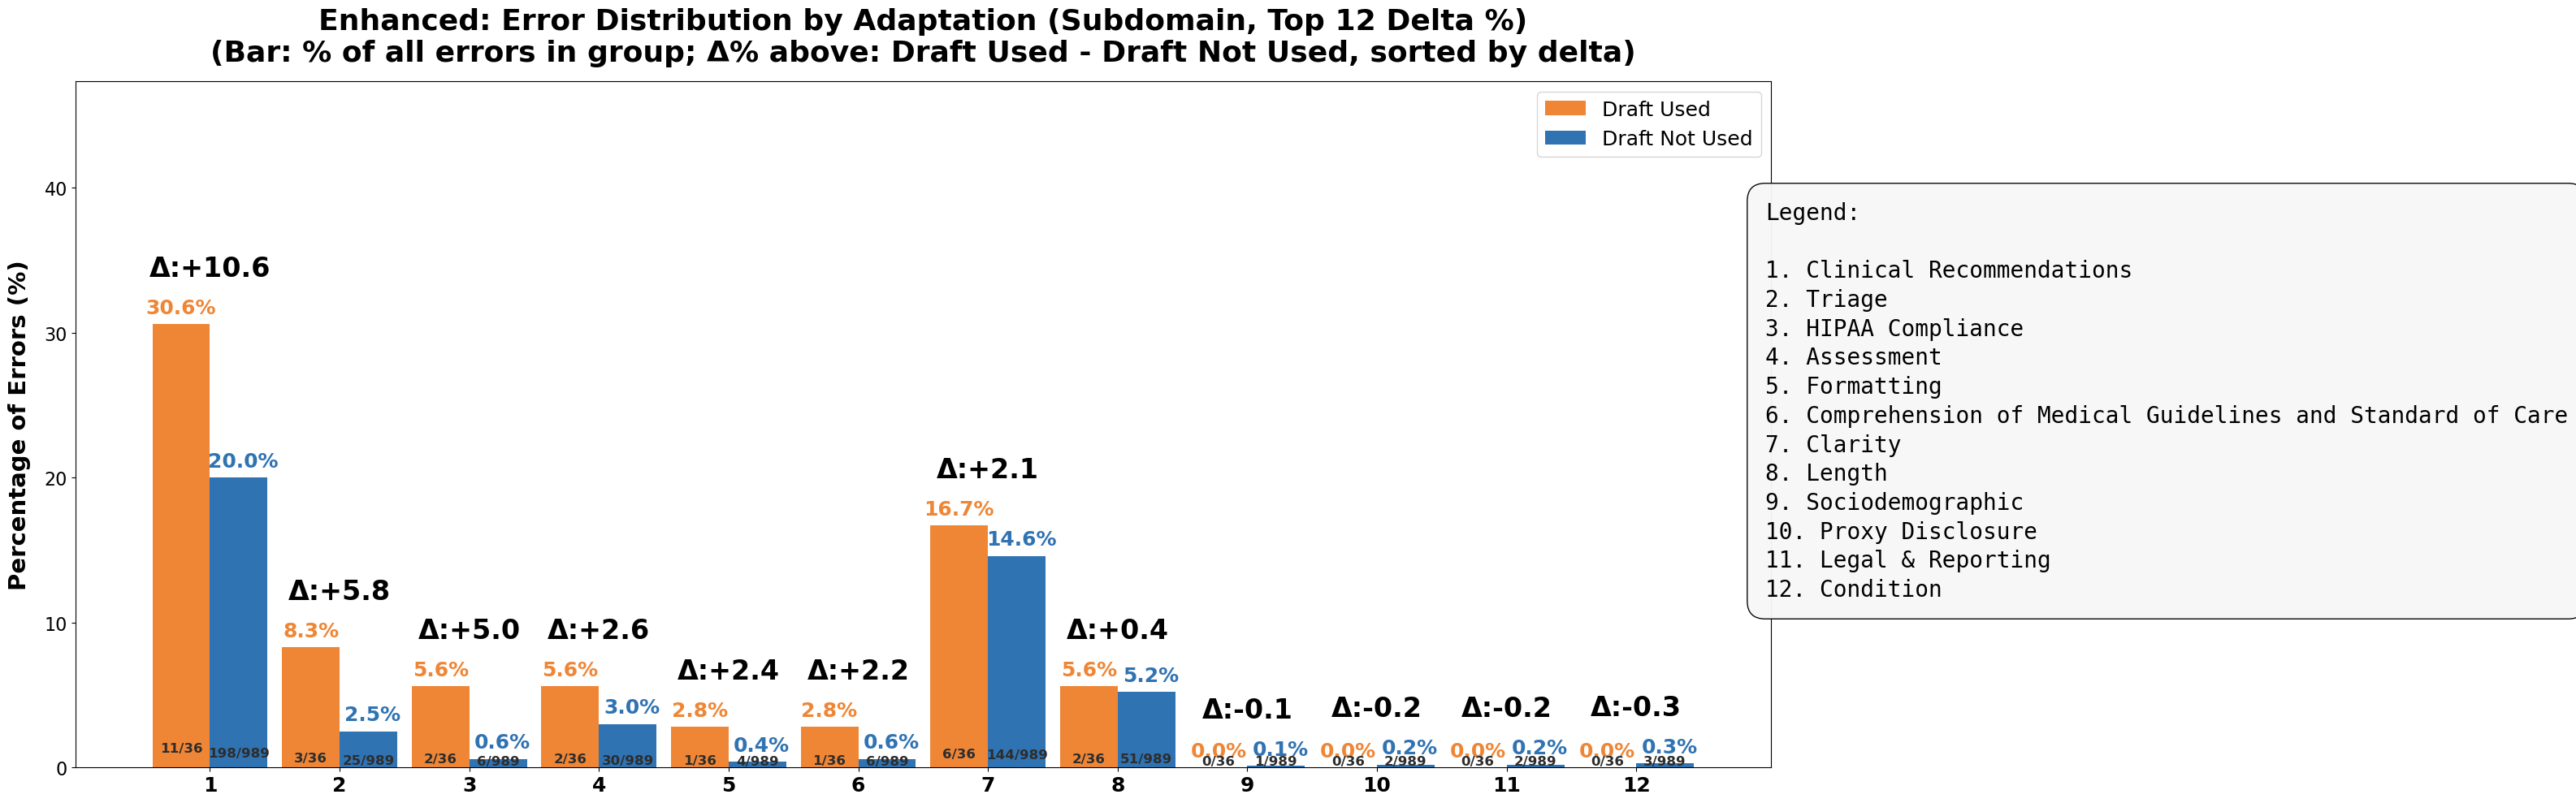

In [ ]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="subdomain", top_n=12)

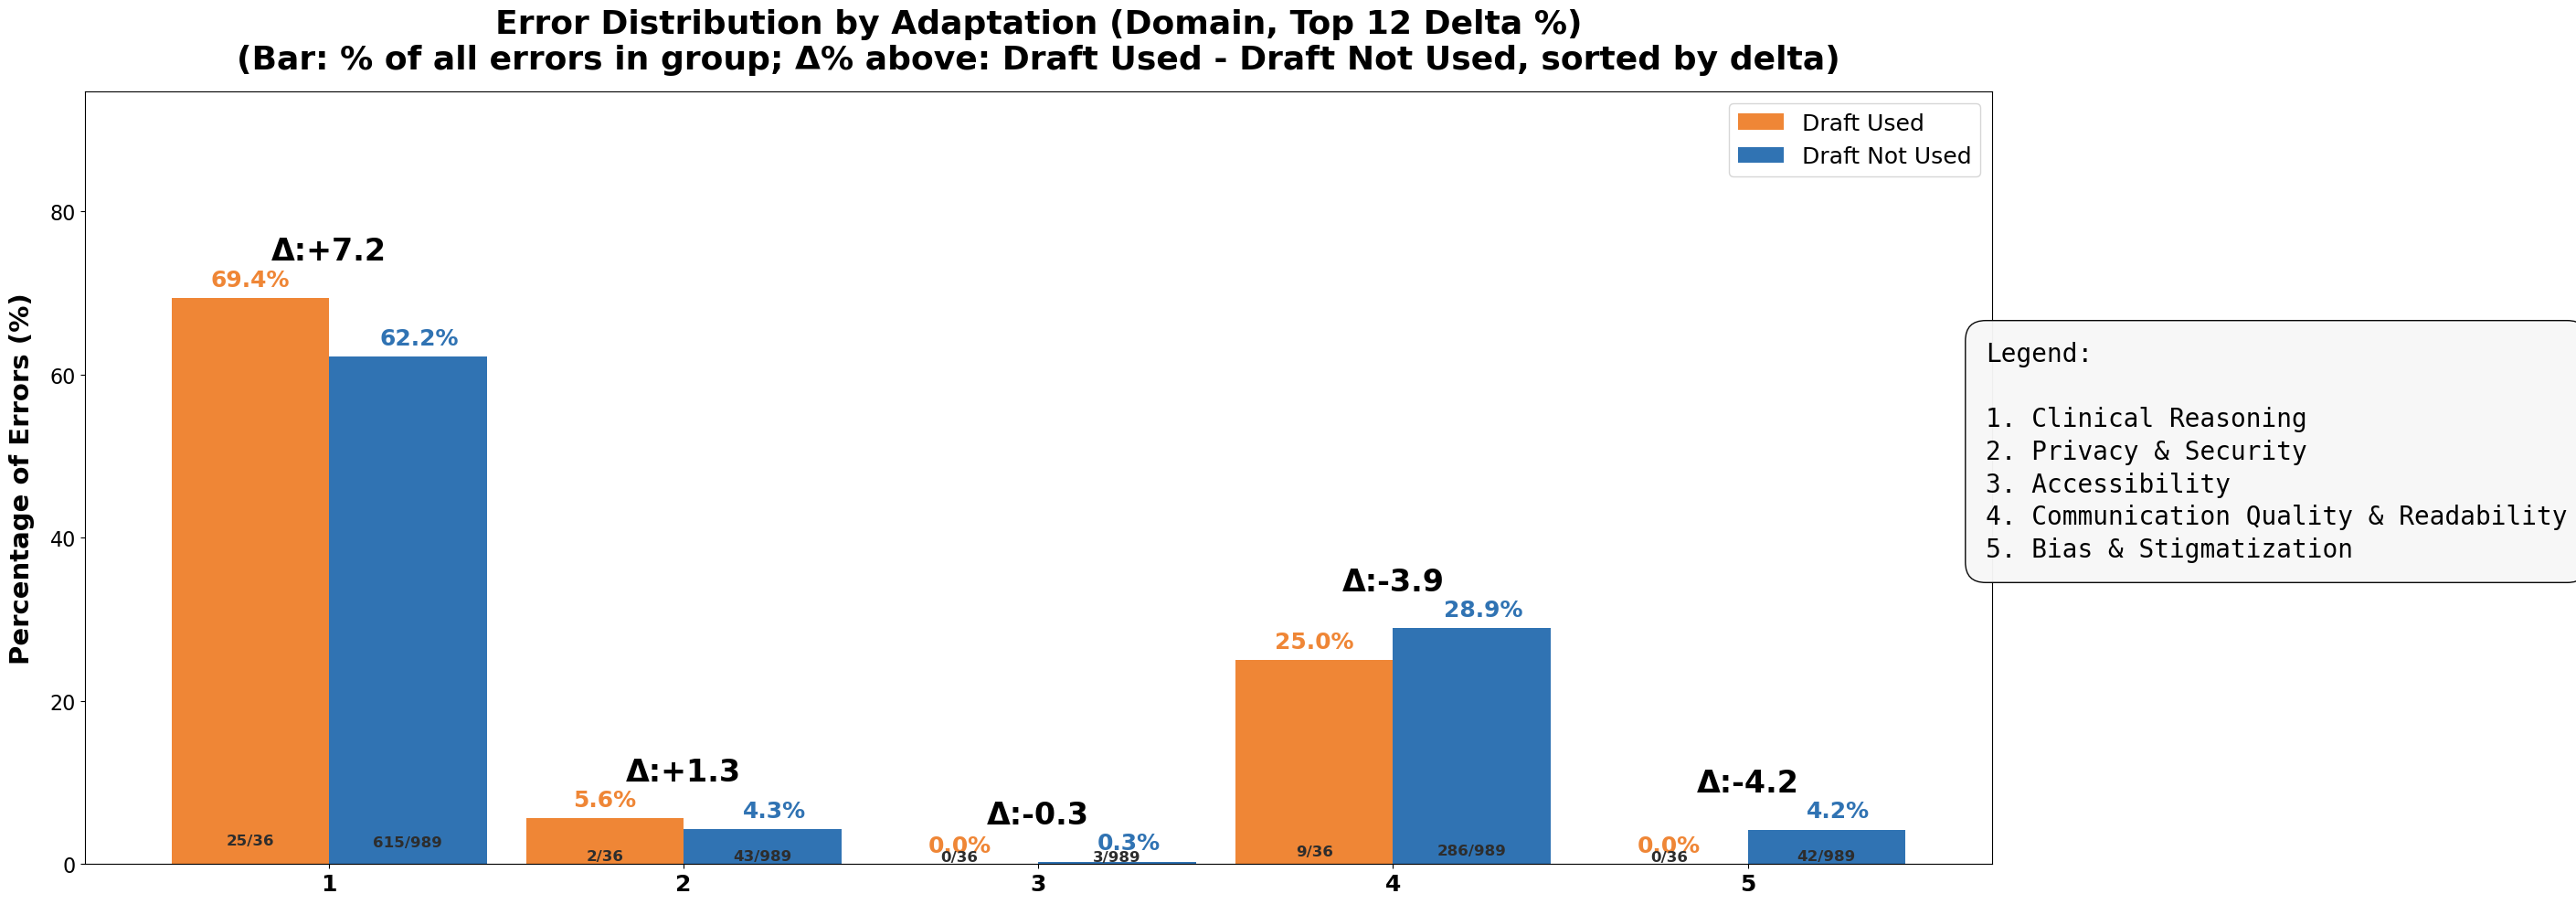

In [129]:
plot_adaptation_grouped_bar_with_number_legend(df_full_enhance_merged, group_col="domain", top_n=12)

In [136]:
df_full_enhance_merged["error_code_yes"].value_counts()

error_code_yes
False    91605
True      1025
Name: count, dtype: int64

In [138]:
df_full_baseline_merged["error_code_yes"].value_counts()

error_code_yes
False    91459
True      1170
Name: count, dtype: int64

In [204]:
import matplotlib.pyplot as plt
import numpy as np

def plot_adaptation_grouped_bar_message_level(
    df,
    group_col="subdomain",
    top_n=12,
    font_scale=1.2,
    figsize=(22, 10),
    type = "pos"
):
    # Ensure we have unique message ids
    if 'index' not in df.columns:
        raise ValueError("DataFrame must have a unique 'message_id' column for message-level analysis.")

    # For each message, figure out if it has >=1 error in each group_col
    msg_group = df.groupby(['index', group_col, 'adapted'])['error_code_yes'].max().reset_index()
    msg_group = msg_group[msg_group['error_code_yes'] == True]  # only those messages that have ≥1 error in that group_col

    # Total messages in each adaptation group
    total_msgs = df.drop_duplicates('index').groupby('adapted')['index'].count().to_dict()
    # Count of messages with at least one error in this group_col and adaptation status
    counts = msg_group.groupby([group_col, 'adapted'])['index'].nunique().unstack(fill_value=0)
    for col in [True, False]:
        if col not in counts.columns:
            counts[col] = 0

    # Compute percentages: out of *all messages* in each group, what % had error of this type
    pct_adapted = (counts[True] / total_msgs.get(True, 1) * 100).round(1) if total_msgs.get(True, 0) > 0 else np.zeros_like(counts[True])
    pct_notadapted = (counts[False] / total_msgs.get(False, 1) * 100).round(1) if total_msgs.get(False, 0) > 0 else np.zeros_like(counts[False])
    pct_diff = pct_adapted - pct_notadapted

    # # --- Select top N by absolute difference ---
    # top_idx = pct_diff.abs().sort_values(ascending=False).index[:top_n]
    # top_diff = pct_diff.loc[top_idx]

    # # Group: positives first (descending), then negatives (ascending)
    # pos_idx = top_diff[top_diff >= 0].sort_values(ascending=False).index
    # neg_idx = top_diff[top_diff < 0].sort_values(ascending=True).index
    # sorted_idx = list(pos_idx) + list(neg_idx)

    # # --- Get top 6 positive and top 6 negative deltas ---
    # top_n_each = top_n // 2
    # pos_idx = pct_diff[pct_diff > 0].sort_values(ascending=False).index[:top_n_each]
    # neg_idx = pct_diff[pct_diff < 0].sort_values(ascending=True).index[:top_n_each]
    # sorted_idx = list(pos_idx) + list(neg_idx)
    if type == "pos":
        top_idx = pct_diff[pct_diff > 0].sort_values(ascending=False).index[:top_n]
        sorted_idx = list(top_idx)
    elif type == "neg":
        top_idx = pct_diff[pct_diff < 0].sort_values(ascending=True).index[:top_n]
        sorted_idx = list(top_idx)
    else:
        raise ValueError("Invalid type. Must be 'pos' or 'neg'.")




    label_nums = [str(i+1) for i in range(len(sorted_idx))]
    label_legend = [f"{i+1}. {lbl}" for i, lbl in enumerate(sorted_idx)]

    pct_adapted_plot = pct_adapted.reindex(sorted_idx, fill_value=0)
    pct_notadapted_plot = pct_notadapted.reindex(sorted_idx, fill_value=0)
    counts_plot = counts.reindex(sorted_idx, fill_value=0)
    pct_diff_plot = pct_diff.reindex(sorted_idx, fill_value=0)

    adapted_count = counts_plot[True].values
    notadapted_count = counts_plot[False].values
    adapted_total = total_msgs.get(True, 0)
    notadapted_total = total_msgs.get(False, 0)
    ind = np.arange(len(label_nums)) * 1.8
    width = 0.8

    fig, ax = plt.subplots(figsize=figsize)
    bars_ad = ax.bar(ind - width/2, pct_adapted_plot, width, label='Draft Used', color='#ef8636', zorder=2)
    bars_na = ax.bar(ind + width/2, pct_notadapted_plot, width, label='Draft Not Used', color='#3073b3', zorder=1)

    percent_font = int(15 * font_scale)
    delta_font = int(20 * font_scale)
    fraction_font = int(10 * font_scale)

    y_top_buffer = 0.5

    for i in range(len(ind)):
        y_top = max(pct_adapted_plot[i], pct_notadapted_plot[i])
        ax.annotate(
            f"Δ:{pct_diff_plot.iloc[i]:+,.1f}",
            xy=(ind[i], y_top + y_top_buffer),
            xytext=(0, 12), textcoords='offset points',
            ha='center', va='bottom',
            fontsize=delta_font, color='black', fontweight='bold'
        )

    for i, (rect_ad, rect_na) in enumerate(zip(bars_ad, bars_na)):
        # Adapted bar (left)
        ax.annotate(
            f"{pct_adapted_plot[i]:.1f}%",
            xy=(rect_ad.get_x() + rect_ad.get_width() / 2, rect_ad.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=percent_font, color='#ef8636', fontweight='bold'
        )
        # ax.annotate(
        #     f"{adapted_count[i]}/{adapted_total}",
        #     xy=(rect_ad.get_x() + rect_ad.get_width() / 2, 0.03*rect_ad.get_height()),
        #     ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
        # )
        # Not Adapted bar (right)
        ax.annotate(
            f"{pct_notadapted_plot[i]:.1f}%",
            xy=(rect_na.get_x() + rect_na.get_width() / 2 + 0.06, rect_na.get_height()),
            xytext=(0, 6), textcoords='offset points',
            ha='center', va='bottom', fontsize=percent_font, color='#3073b3', fontweight='bold'
        )
        # ax.annotate(
        #     f"{notadapted_count[i]}/{notadapted_total}",
        #     xy=(rect_na.get_x() + rect_na.get_width() / 2, 0.03*rect_na.get_height()),
        #     ha='center', va='bottom', fontsize=fraction_font, color='#2d2d2d', fontweight='bold'
        # )

    y_max_bar = max(np.concatenate([pct_adapted_plot, pct_notadapted_plot])) if (len(pct_adapted_plot) and len(pct_notadapted_plot)) else 1
    ax.set_ylim(top=y_max_bar * 1.22 + 10)
    ax.set_ylabel('Percentage of Messages with Error (%)', fontsize=int(18*font_scale), fontweight='bold', labelpad=12)
    ax.set_xticks(ind)
    ax.set_xticklabels(label_nums, fontsize=int(15*font_scale), fontweight='bold')
    # ax.set_title(
    #     f"Message-level Error Distribution by Adaptation ({group_col.capitalize()}, Top {top_n} {type} Δ%)\n"
    #     "(Bar: % of messages with ≥1 error in group; Δ% above: Draft Used - Draft Not Used)",
    #     fontsize=int(22*font_scale), fontweight='bold', pad=18)
    ax.legend(fontsize=int(15*font_scale), loc='upper right')
    ax.tick_params(axis='y', labelsize=int(14*font_scale))
    ax.set_ylim(0, 15)
    if type == "pos":
        ax.set_ylim(0, 8)
    # plt.subplots_adjust(left=0.06, right=0.78, bottom=0.18, top=0.82)
    # plt.tight_layout()

    # # Draw legend of numbered labels
    # legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
    # plt.gcf().text(
    #     0.99, 0.5, "Legend:\n\n" + legend_text,
    #     va='center', ha='left',
    #     fontsize=int(17*font_scale), fontweight='normal',
    #     family="monospace",
    #     bbox=dict(boxstyle="round,pad=0.8", edgecolor="black", facecolor="#f7f7f7", alpha=0.97),
    #     linespacing=1.35
    # )
    plt.subplots_adjust(left=0.06, right=0.97, bottom=0.23, top=0.82)
    plt.tight_layout(rect=[0, 0.12, 1, 1])  # leave space at the bottom for the legend

    # Draw legend of numbered labels UNDERNEATH
    legend_text = "\n".join([x for x in label_legend if x.strip() != ""])
    plt.figtext(
        0.5, 0.1, "Legend:\n\n" + legend_text,
        va='top', ha='center',
        fontsize=int(15*font_scale), fontweight='normal',
        family="monospace",
        bbox=dict(boxstyle="round,pad=0.6", edgecolor="black", facecolor="#f7f7f7", alpha=0.96),
        linespacing=1.25
)


    plt.show()


/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_top = max(pct_adapted_plot[i], pct_notadapted_plot[i])
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{pct_adapted_plot[i]:.1f}%",
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

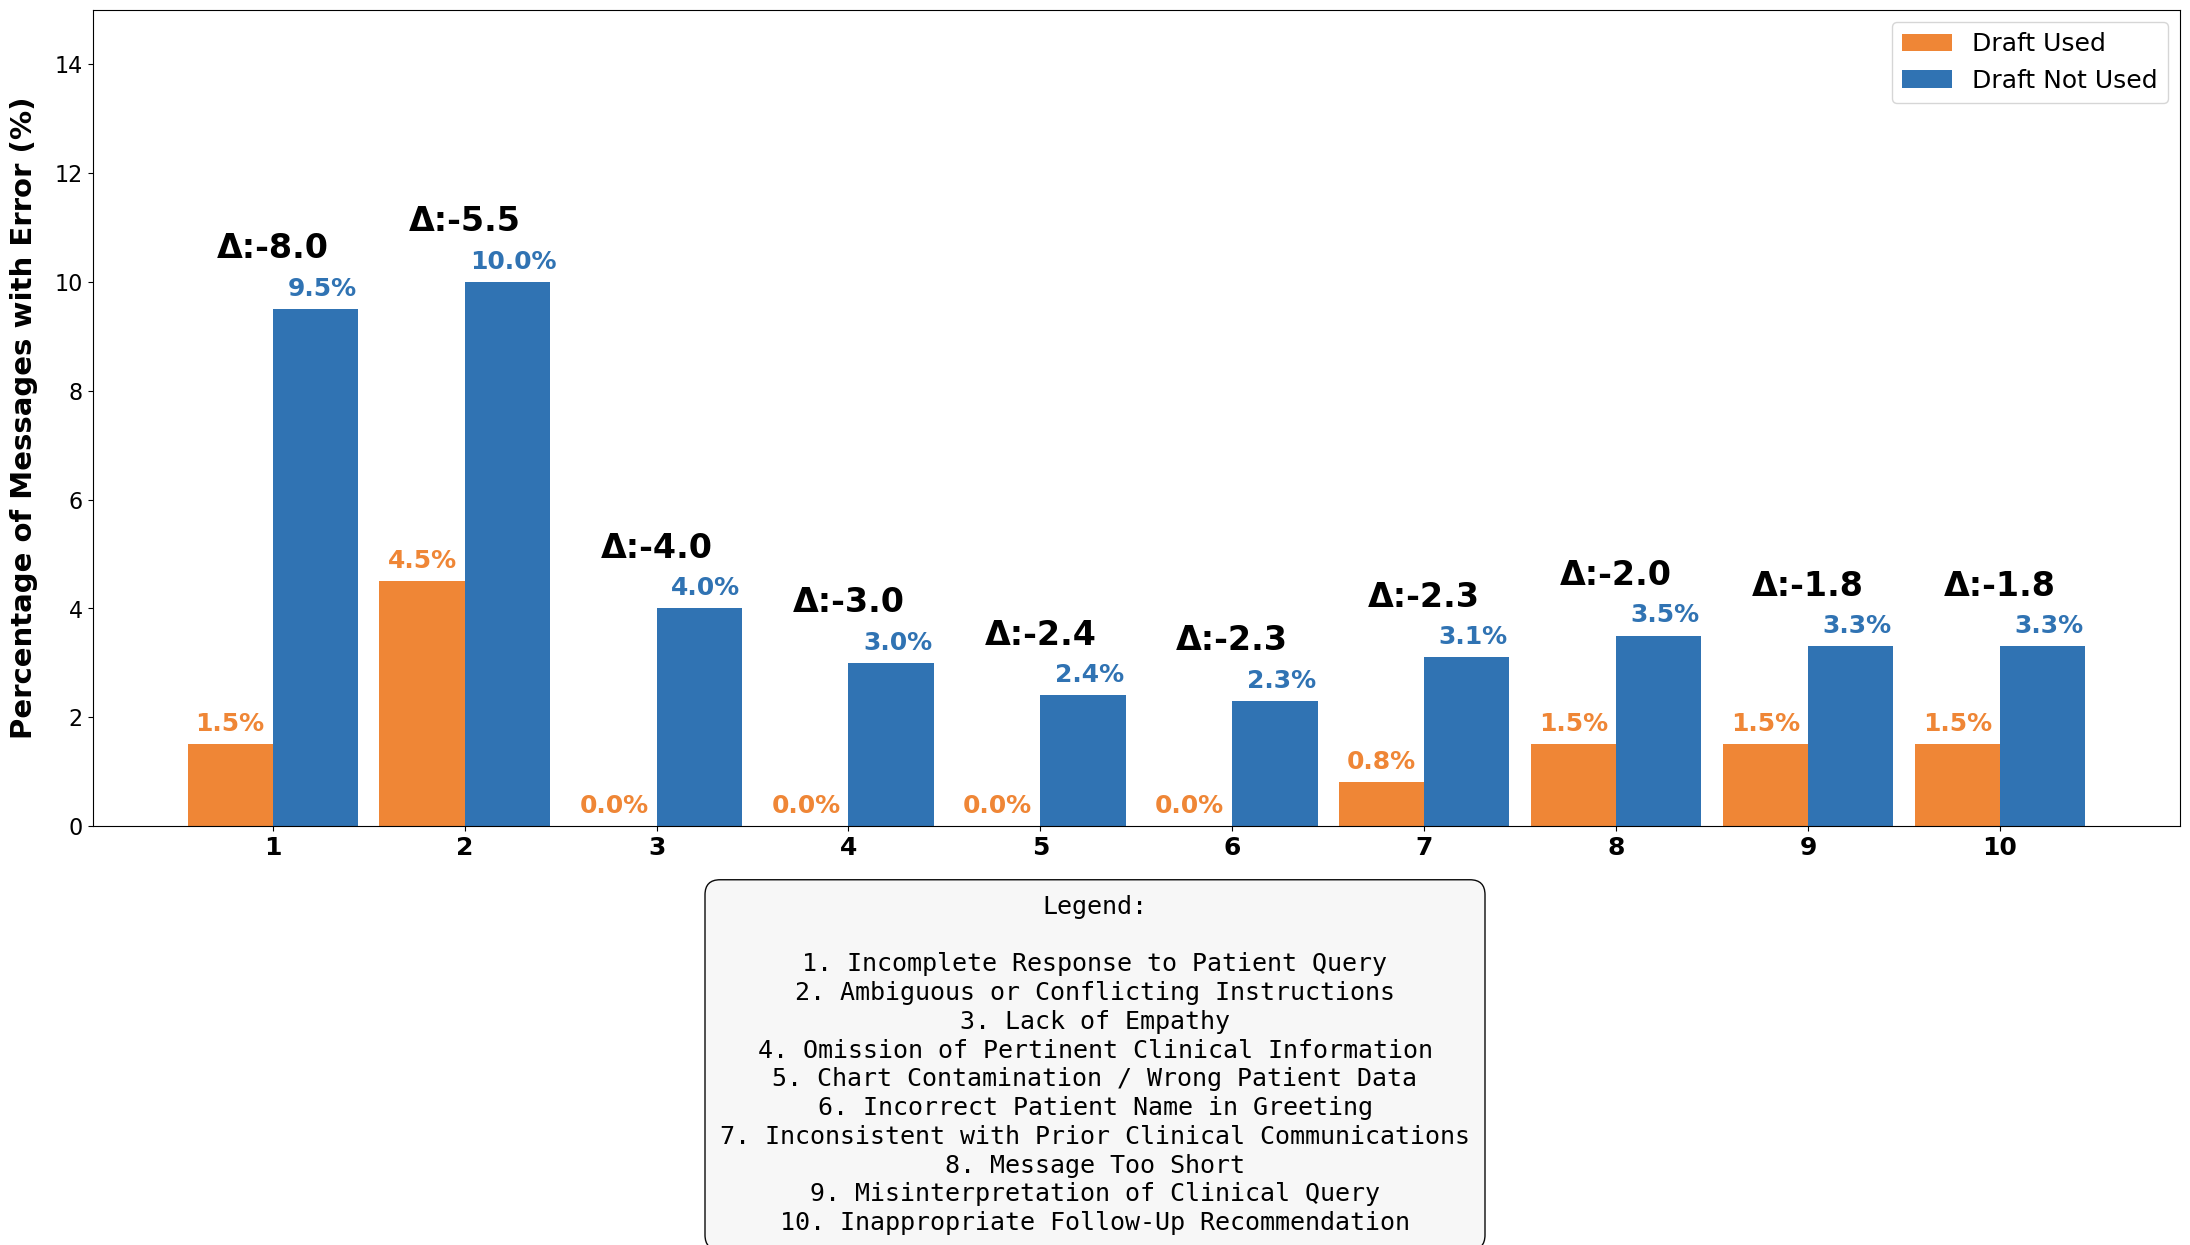

In [205]:
plot_adaptation_grouped_bar_message_level(df_full_enhance_merged, group_col="error_code", top_n=10, type="neg")

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_top = max(pct_adapted_plot[i], pct_notadapted_plot[i])
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{pct_adapted_plot[i]:.1f}%",
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_92614/1004031465.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

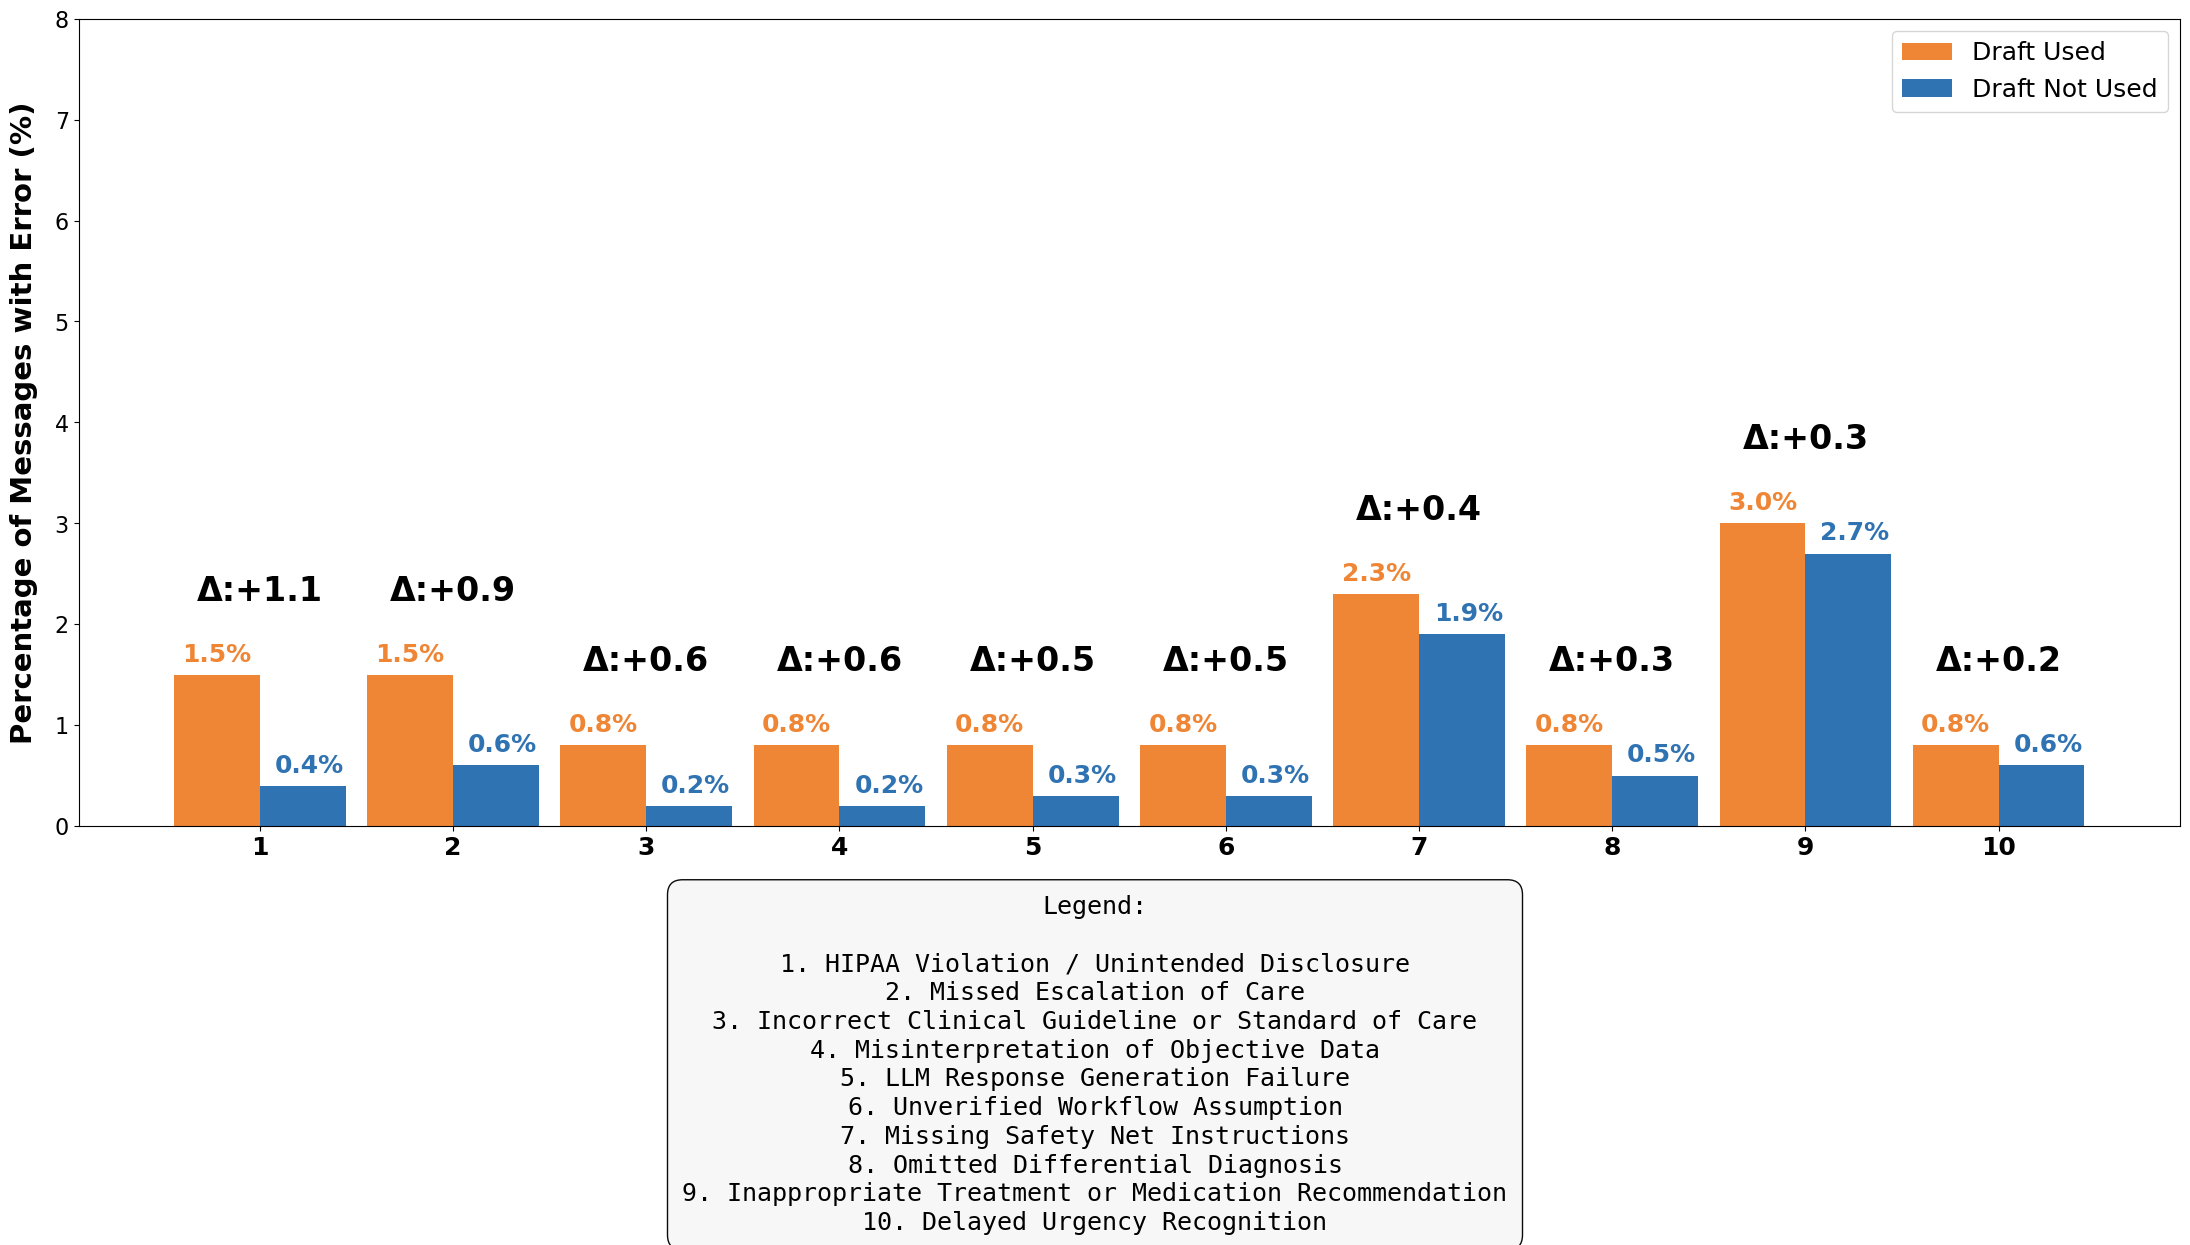

In [206]:
plot_adaptation_grouped_bar_message_level(df_full_enhance_merged, group_col="error_code", top_n=10, type="pos")